In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from termcolor import colored
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.special as sc
import seaborn as sns
import pickle

In [3]:
# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# Globally setting font sizes via rcParams should be done with 

params = {
    'font.size': 11,
    'figure.figsize': (10,4),
    'figure.dpi': 80,
    'savefig.dpi': 300,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.labelsize': 11,
    'axes.axisbelow': True
         }
plt.rcParams.update(params)


# The defaults can be restored using
# plt.rcParams.update(plt.rcParamsDefault)

In [5]:
# bound_is = 750
experiment_length = 1800

In [6]:
main_folder = os.getcwd()
# folder_experiments = 'results/ALL/Real'
# folder_experiments = 'results/ALL/Simulated/bias_experiment_100_runs'
# folder_experiments = 'results/ALL/Simulated/bouncing_angle_100_runs'
# folder_experiments = 'results/ALL/Simulated/random_angle_100_runs'
folder_experiments = 'results/ALL/Simulated/simple_experiment_100_runs'

In [7]:
def check_float(potential_float):
    try:
        float(potential_float)
        return True

    except ValueError:
        return False

In [8]:
def to_pkl(data, data_name):
    # create a binary pickle file 
    f = open(data_name+'.pkl',"wb")

    # write the python object (dict) to pickle file
    pickle.dump(data,f)

    # close file
    f.close()
    
def from_pkl(data_name):
    file = open(data_name+'.pkl','rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

In [9]:
def sort_nested_dict(dictionary):
    temp = dict()
    for k1, val1 in sorted(dictionary.items()):
        temp[k1] = dict()
        for k2, val2 in sorted(val1.items()):
            temp[k1][k2] = dict()
            for k3, val3 in sorted(val2.items()):
                temp[k1][k2][k3] = val3
    return temp

In [10]:
def evaluate_convergence_time(times):
    conv_times = np.zeros(times.shape[0])
#     print("Time shape", times.shape)
#     print("Timea", times)
    for idx, elem in enumerate(times):
        if (elem[0] == -1):
            conv_times[idx] = elem[1]
        else:
            conv_times[idx] = elem.min()
    # c_time in ticks
    #     conv_time_batch = np.append(conv_time_batch, conv_times.max())
    return conv_times

In [11]:
def KM_estimator(data, censored):
    '''K-M estimator'''
    n_est = np.asarray(range(0, data.size))[::-1] + censored  # array from 29 to 0
    RT_sync = []
    for i in range(n_est.size):
        if len(RT_sync) == 0:
            RT_sync.append((n_est[i] - 1) / n_est[i])
        else:
            RT_sync.append(RT_sync[-1] * ((n_est[i] - 1) / n_est[i]))
    #     print(RT_sync)
    F = 1 - np.asarray(RT_sync).reshape(-1, 1)
    #     print(F)
    return F


def weib_cdf(x, alpha, gamma):
    return (1 - np.exp(-np.power(x / alpha, gamma)))

In [12]:
def weibull_plot(mean, std_dev, times_value, popt_weibull, F, figLabel, figName, conv_time_estimation):
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    '''Textbox with mu and sigma'''
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mean,),
        r'$\sigma=%.2f$' % (std_dev,)))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    y_weib = weib_cdf(times_value, popt_weibull[0], popt_weibull[1])
    error_weib = np.power(y_weib - np.squeeze(F), 2)
    plt.plot(times_value, y_weib, 'r', linewidth=5, label="Weibull Distribution")
    plt.plot(times_value, F, 'b', linewidth=5, label="K-M stats")
    plt.legend(loc=4)
    plt.ylim(0, 1)
    if not conv_time_estimation:
        plt.xlim(0, times_value[-1])

    label = figLabel
    plt.title(label)
    plt.xlabel("Number of time steps")
    if conv_time_estimation:
        plt.ylabel("Synchronisation probability")
    else:
        plt.ylabel("Probability of passing over the target")
    
    plt.tight_layout()
    plt.savefig(os.path.join(main_folder,'Plots',figName))
    print('Saving fig at: ', os.path.join(main_folder,'Plots',figName))
    plt.show()
    
#     plt.close(fig)


In [13]:
def plot_heatmap(dictionary, title, conv_time_estimation):
    for key, value in sorted(dictionary.items()):
        # print("Key value: ", key, value)
        fig = plt.figure()
        dataFrame = pd.DataFrame.from_dict(value)
        reversed_df = dataFrame.iloc[::-1]
        if conv_time_estimation:
            ax = sns.heatmap(reversed_df, annot=True, fmt=".2e", vmin=1500, vmax=3000, cmap="viridis")
        else:
            ax = sns.heatmap(reversed_df, annot=True, fmt=".2e", vmin=10000, vmax=40000, cmap="viridis")
        ax.set_title(title + ", num_robots:%s" % key)
        ax.set_ylabel("alpha")
        ax.set_xlabel("rho")
        #         plt.show()
        # Salva su file
        file_name = title + "_%s_robots.png" % (key)
        plt.savefig(os.path.join(main_folder,'Plots',file_name))
        print('Saving heatmap at: ', os.path.join(main_folder,'Plots',file_name))
        #     reversed_df.to_pickle(file_name[:-4] + ".pickle")
        plt.show()

### Main

Exp type:  simple_experiment_100_runs
DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.8_rho_0.9.png


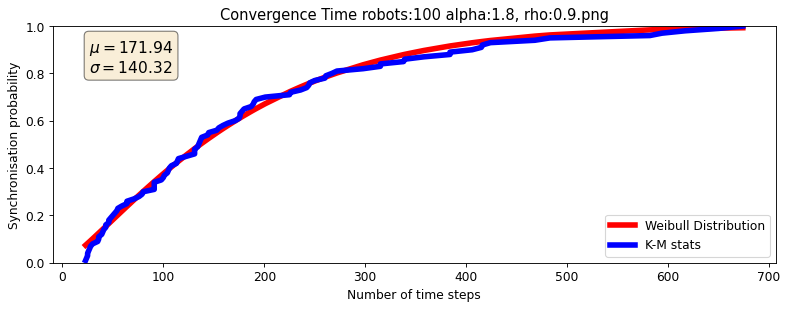

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.8_rho_0.9.png


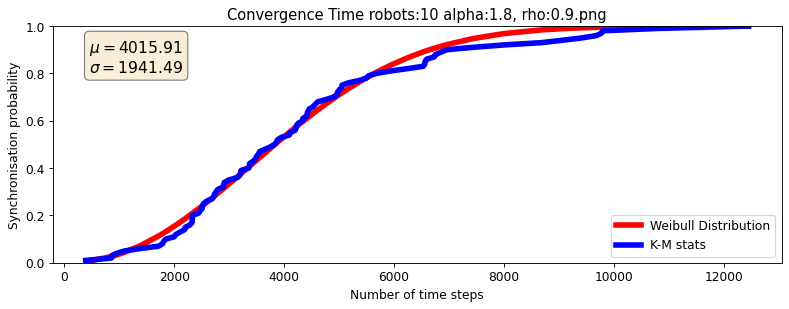

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.6_rho_0.3.png


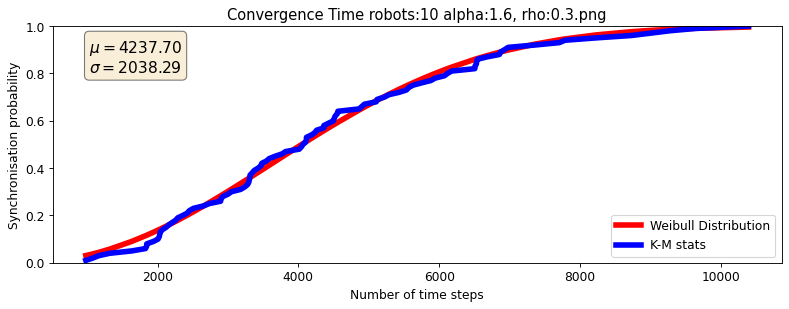

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.6_rho_0.6.png


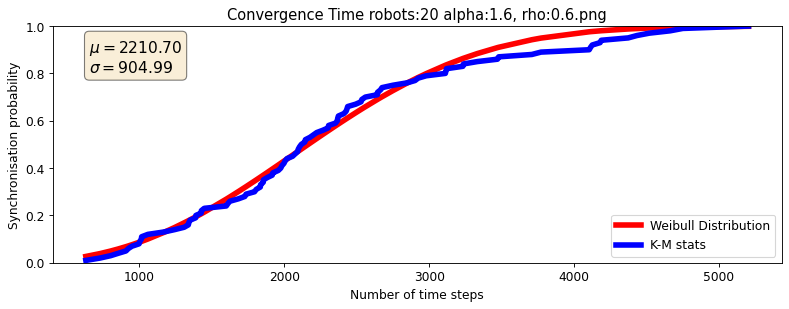

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.3_1800
num_robots 10, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_2.0_rho_0.3.png


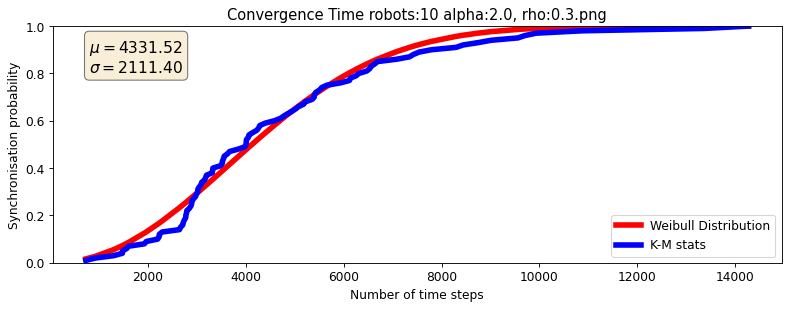

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.3_1800
num_robots 50, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_2.0_rho_0.3.png


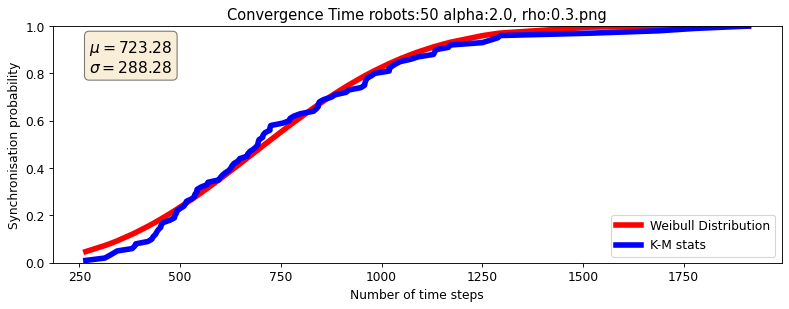

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.4_rho_0.6.png


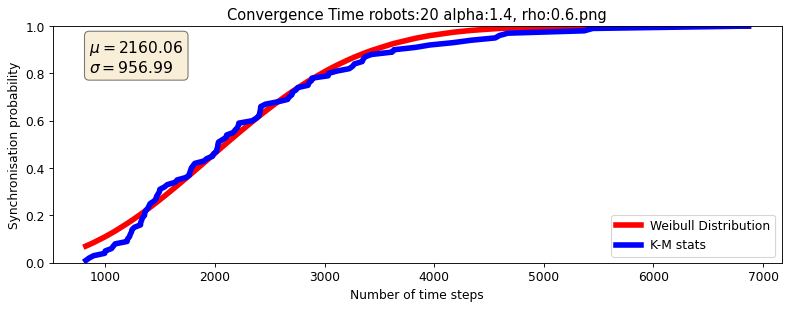

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.8_rho_0.3.png


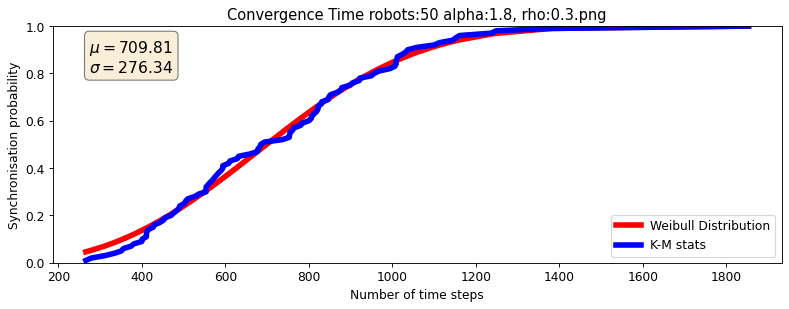

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.2_rho_0.0.png


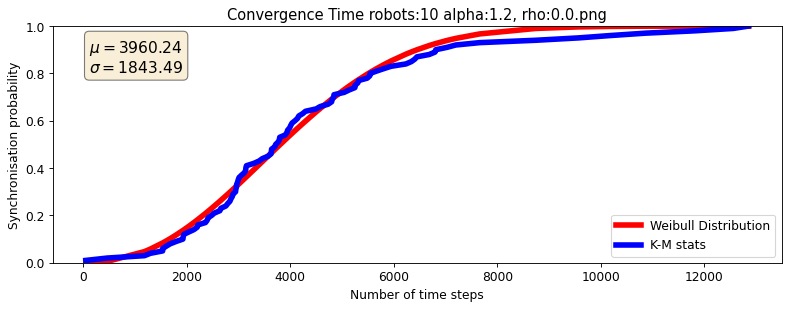

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.3_1800
num_robots 20, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_2.0_rho_0.3.png


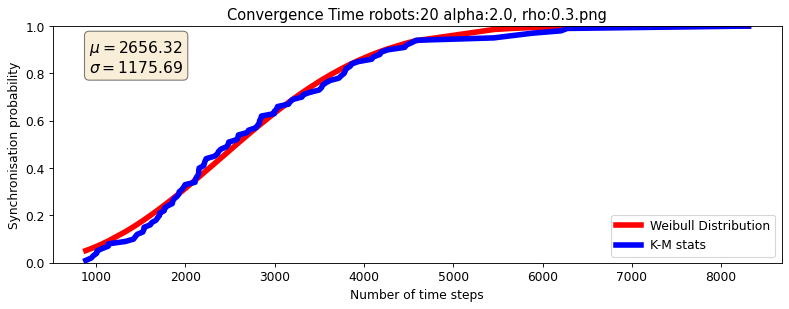

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.8_rho_0.3.png


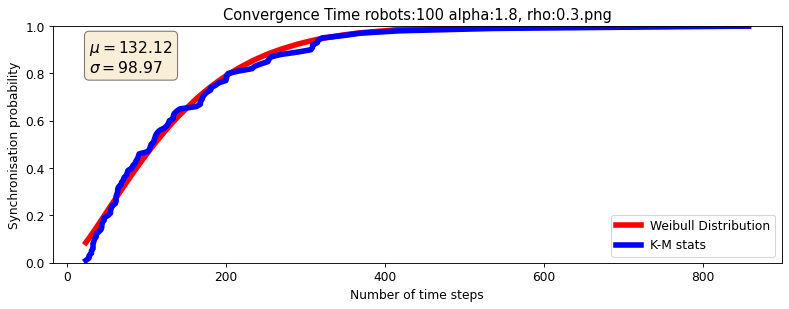

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.8_rho_0.6.png


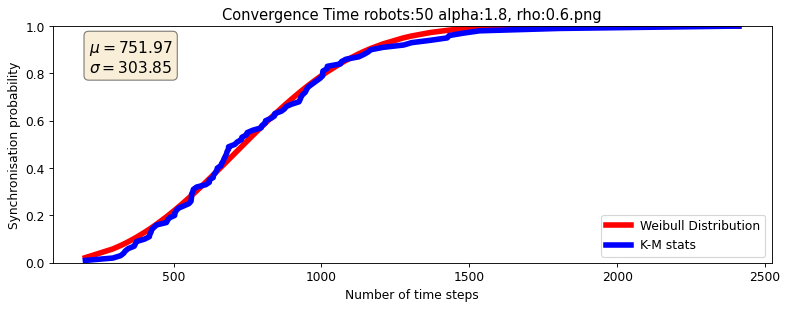

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.2_rho_0.0.png


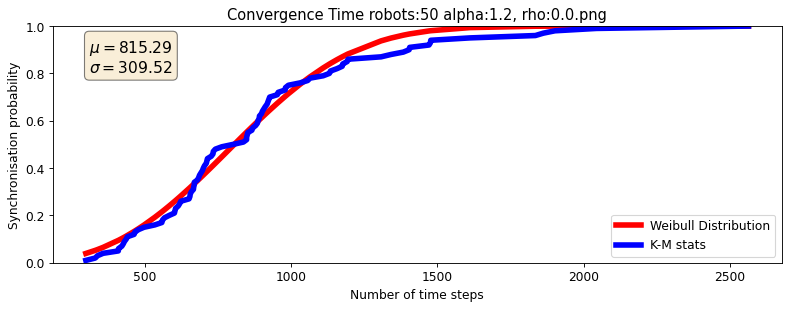

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.2_rho_0.3.png


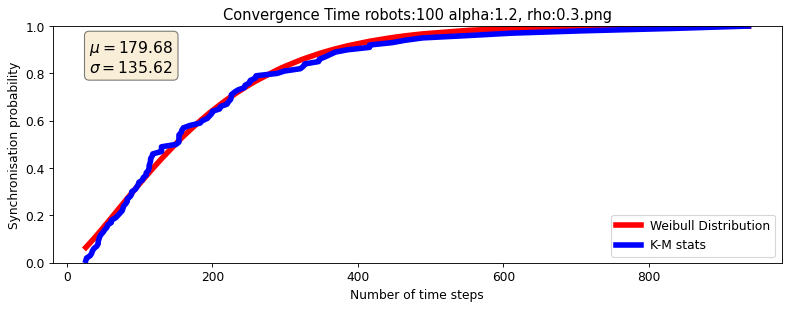

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.4_rho_0.3.png


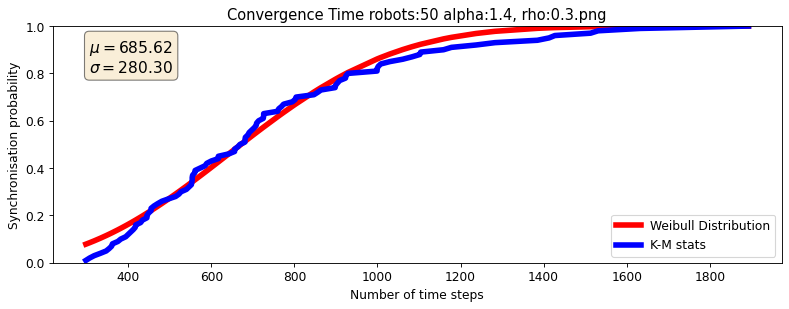

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.6_1800
num_robots 20, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_2.0_rho_0.6.png


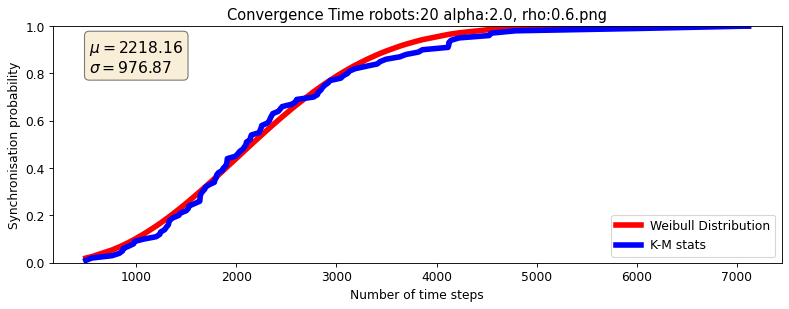

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.4_rho_0.0.png


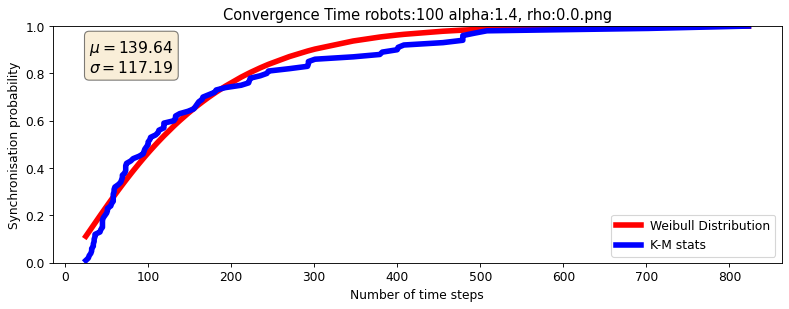

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.2_rho_0.3.png


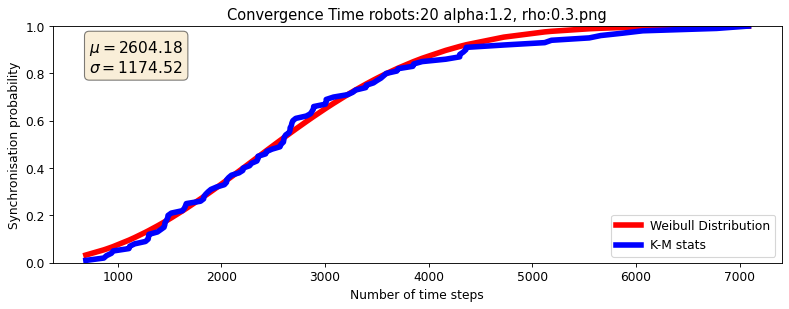

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.8_rho_0.9.png


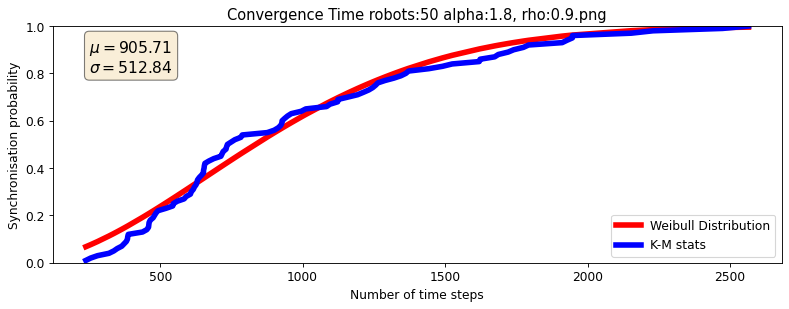

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.6_rho_0.3.png


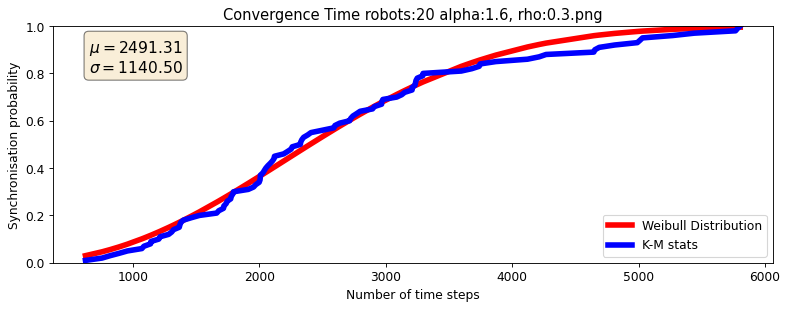

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.6_rho_0.9.png


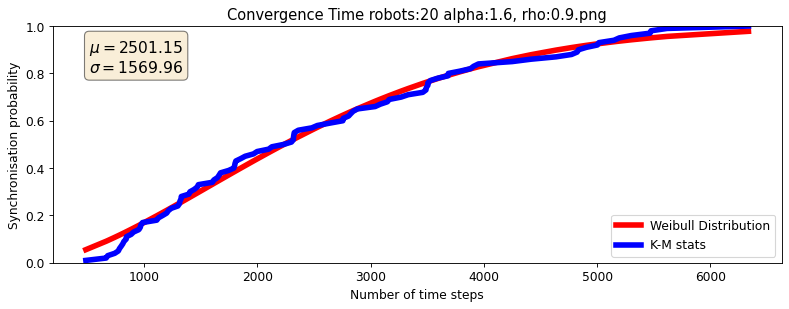

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.8_rho_0.0.png


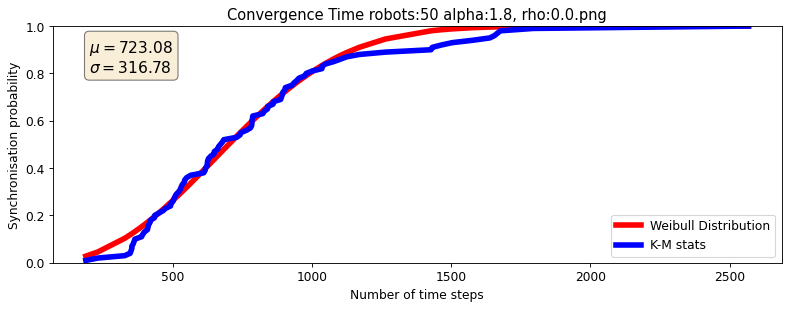

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.4_rho_0.6.png


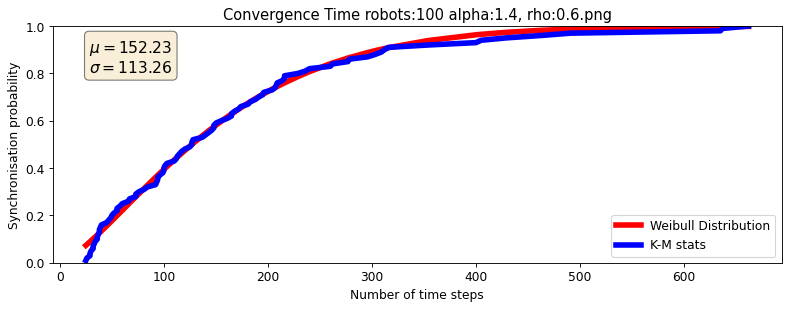

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.8_rho_0.3.png


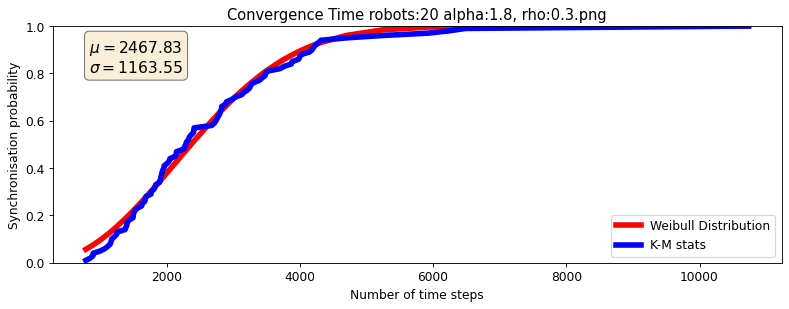

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.6_rho_0.9.png


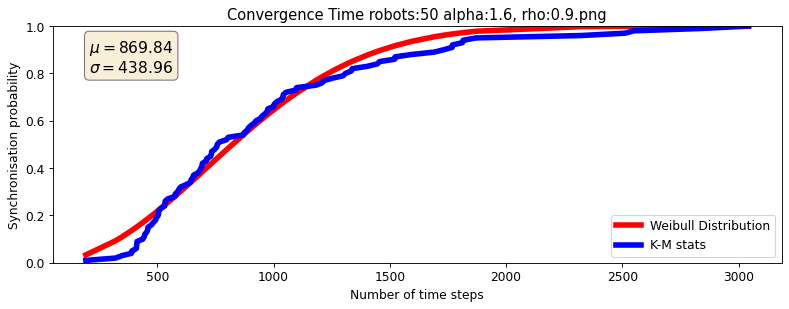

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.8_rho_0.6.png


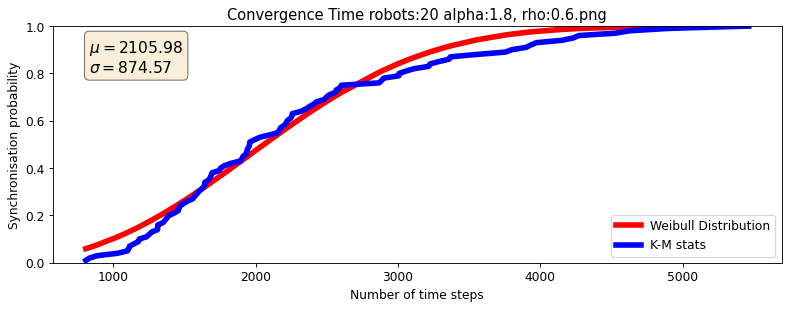

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.8_rho_0.6.png


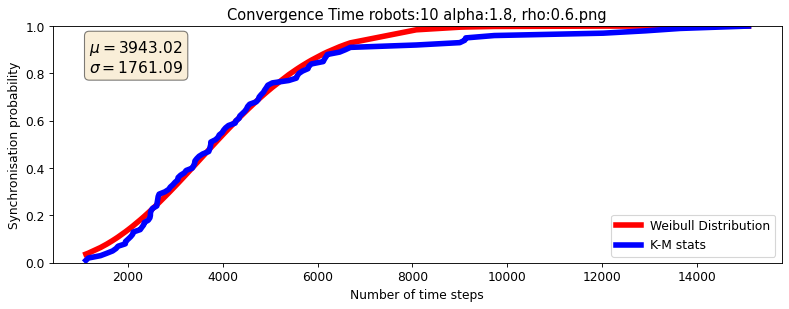

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.6_rho_0.0.png


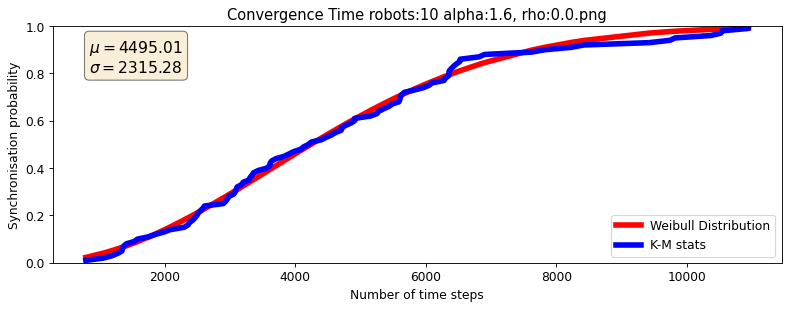

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.2_rho_0.9.png


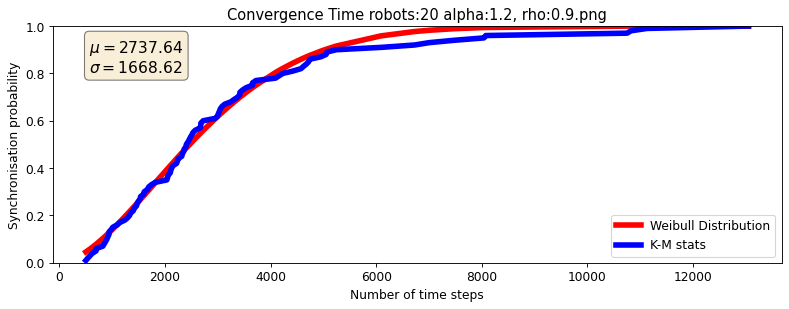

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.8_rho_0.0.png


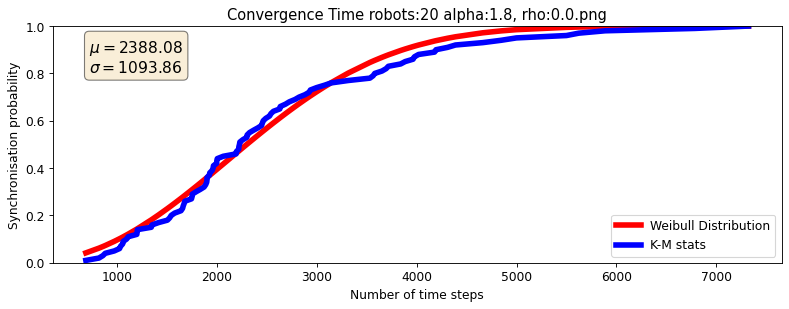

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.2_rho_0.0.png


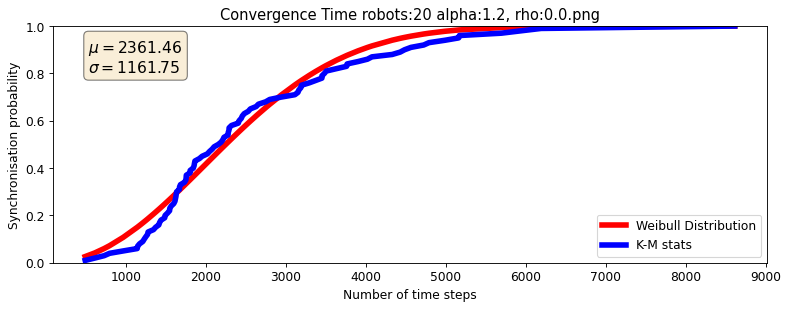

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.8_rho_0.6.png


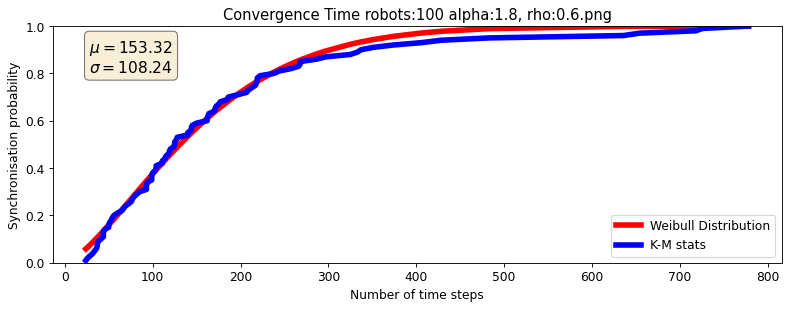

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.2_rho_0.9.png


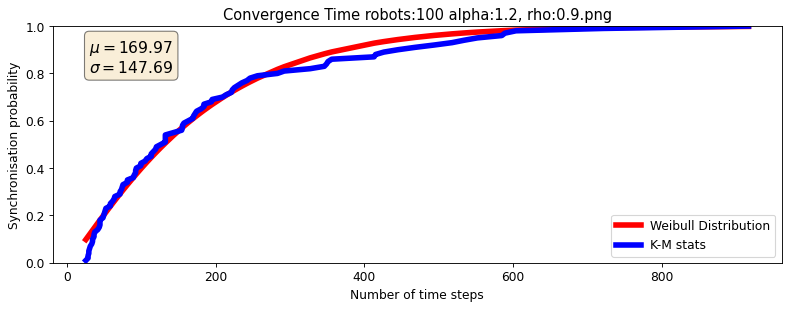

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.4_rho_0.3.png


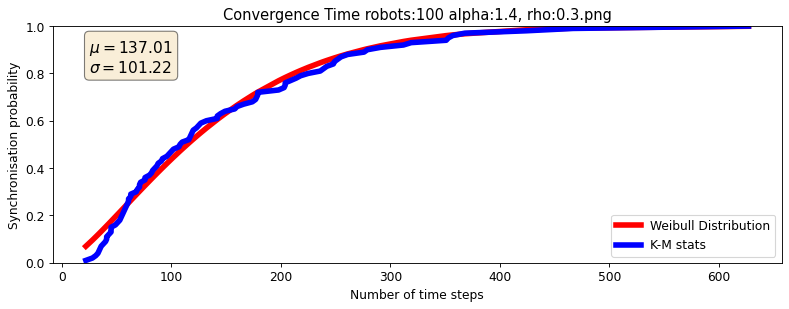

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.4_rho_0.0.png


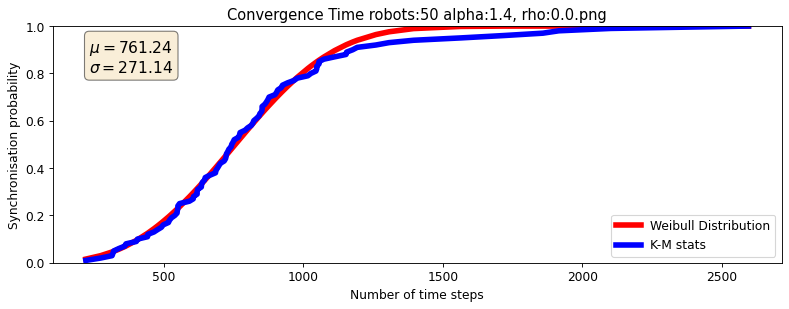

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.9_1800
num_robots 10, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_2.0_rho_0.9.png


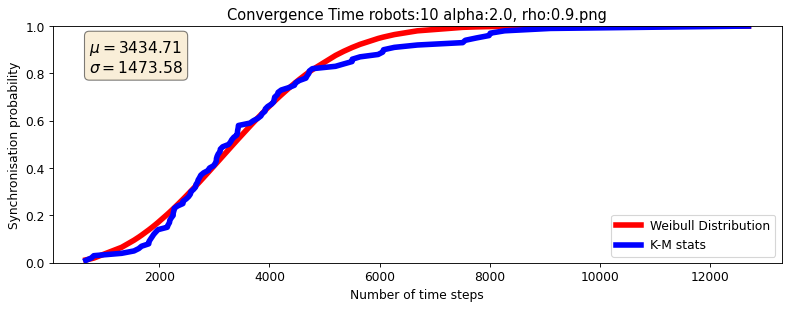

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.6_rho_0.3.png


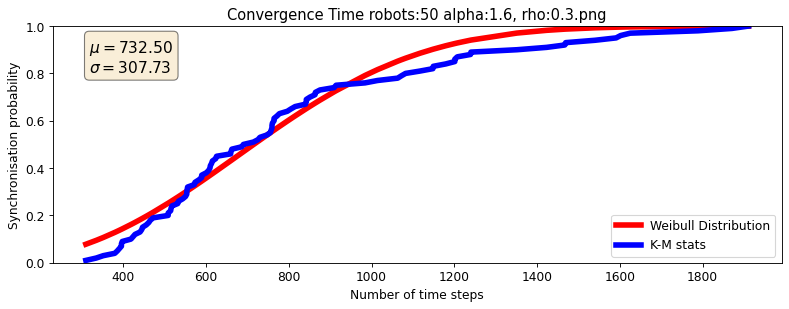

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.6_1800
num_robots 10, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_2.0_rho_0.6.png


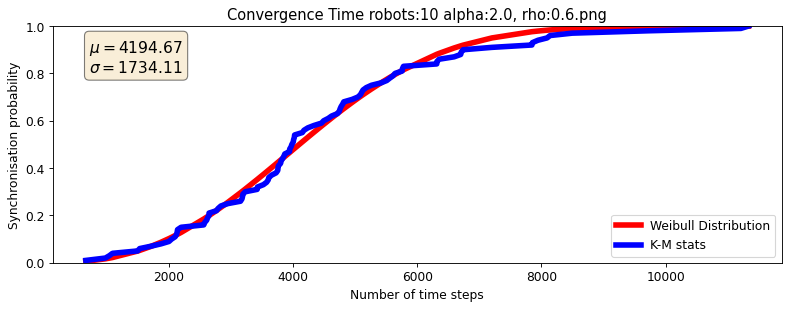

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.2_rho_0.6.png


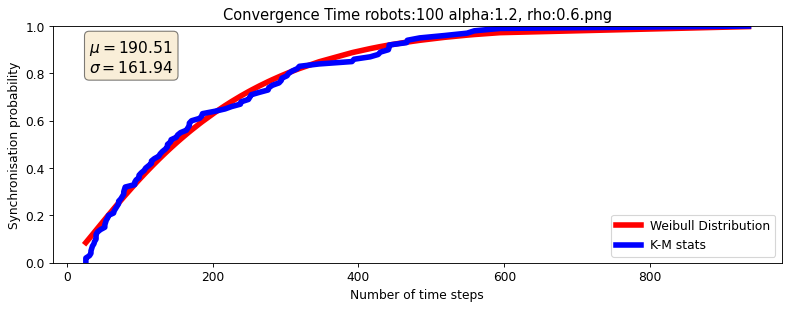

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.4_rho_0.6.png


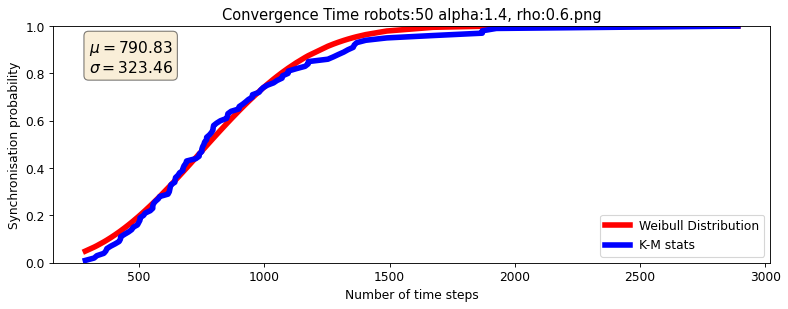

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.2_rho_0.3.png


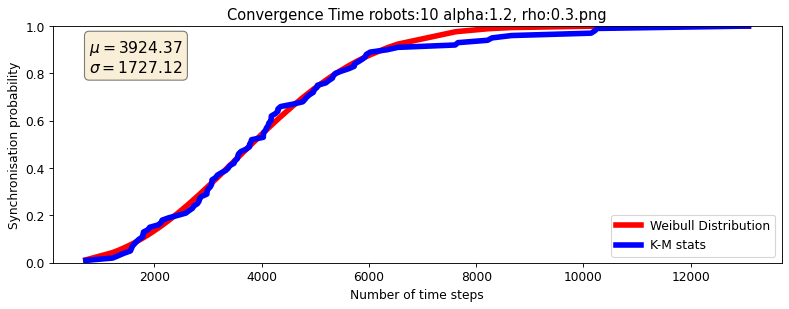

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.2_rho_0.6.png


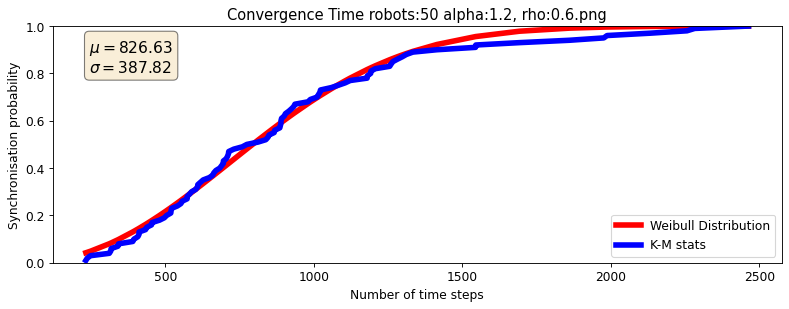

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.6_rho_0.9.png


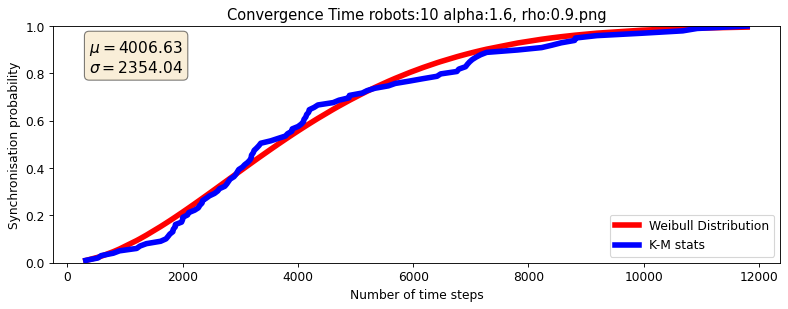

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.6_rho_0.6.png


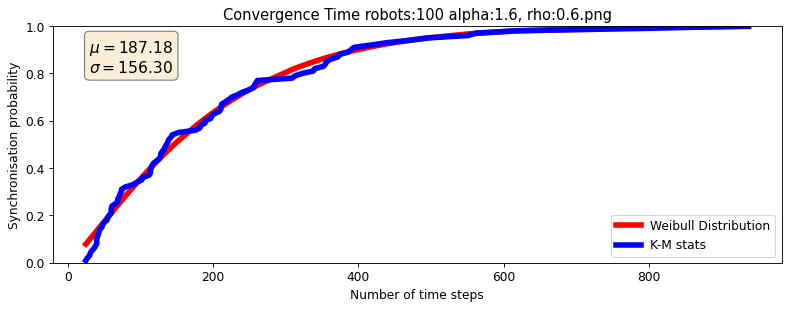

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.6_1800
num_robots 100, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_2.0_rho_0.6.png


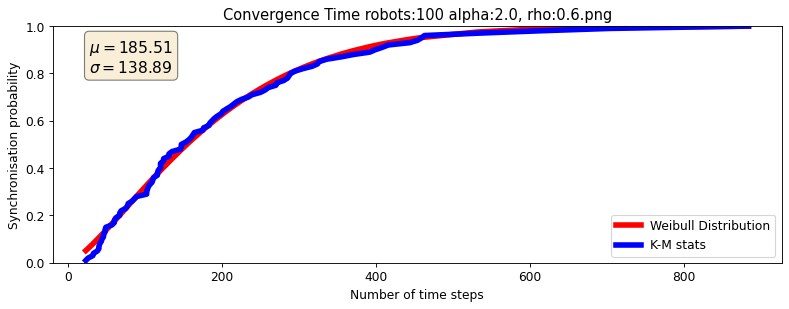

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.6_rho_0.0.png


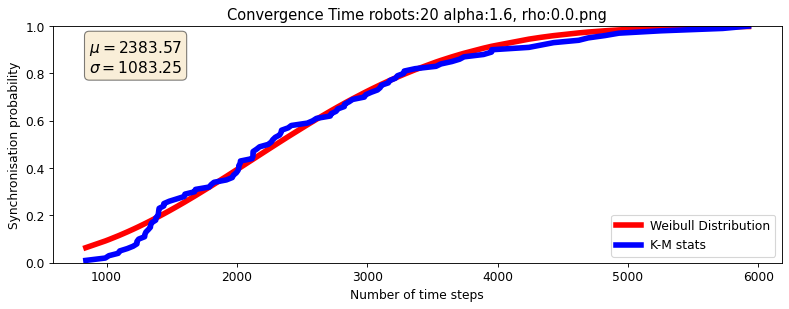

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.4_rho_0.3.png


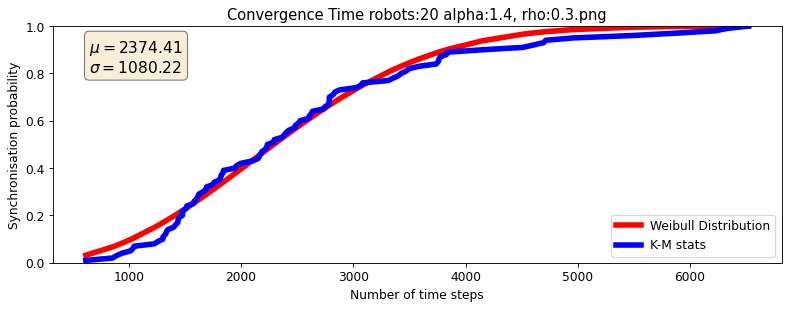

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.0_1800
num_robots 20, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_2.0_rho_0.0.png


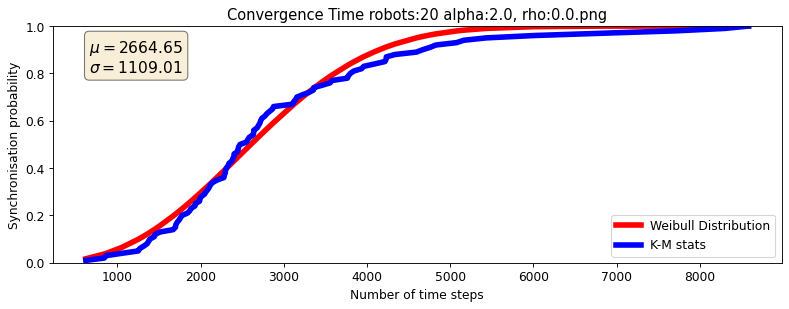

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.6_rho_0.3.png


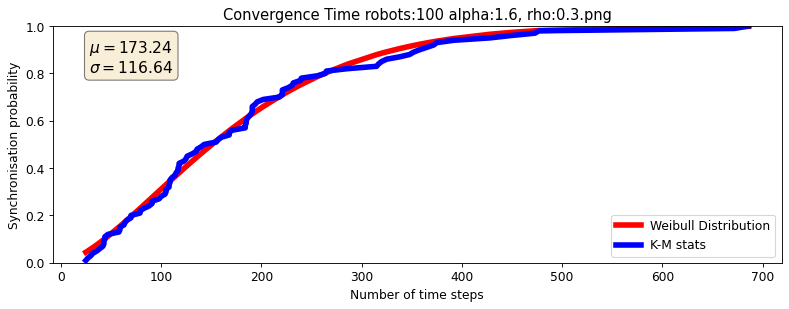

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.4_rho_0.3.png


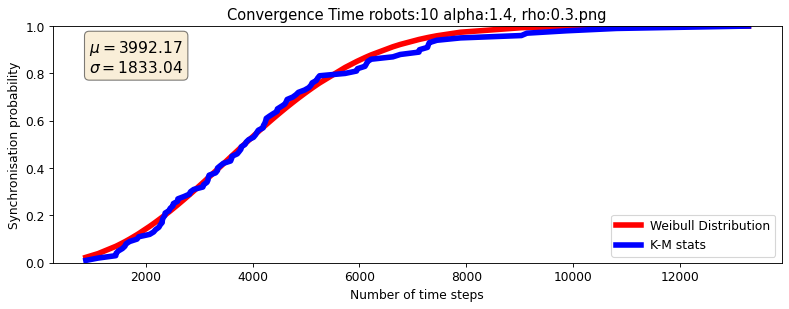

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.8_rho_0.3.png


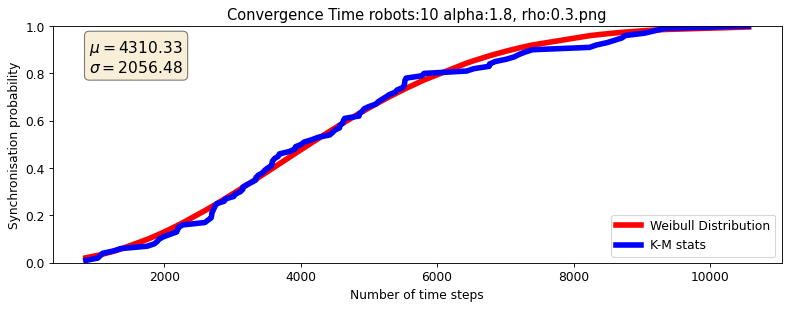

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.0_1800
num_robots 50, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_2.0_rho_0.0.png


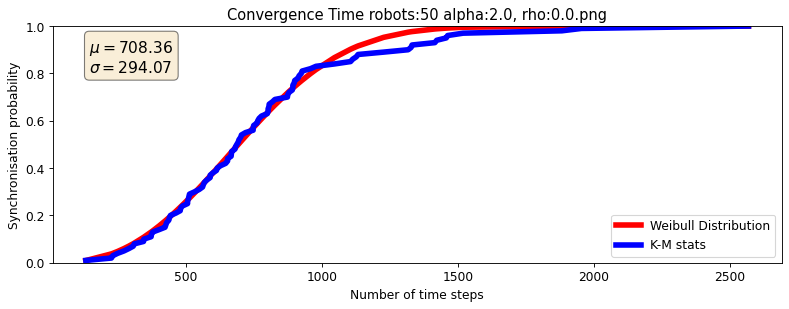

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.4_rho_0.6.png


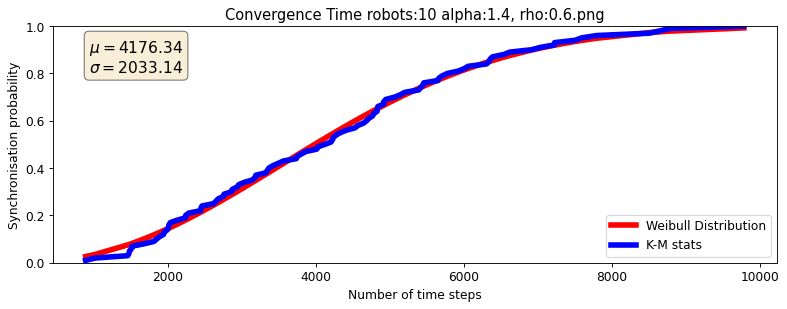

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.2_rho_0.6.png


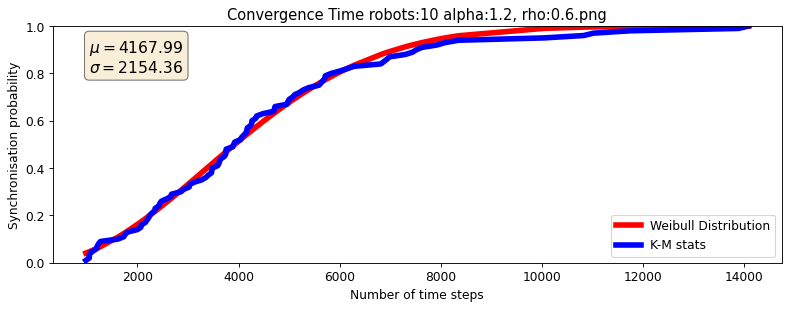

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.2_rho_0.3.png


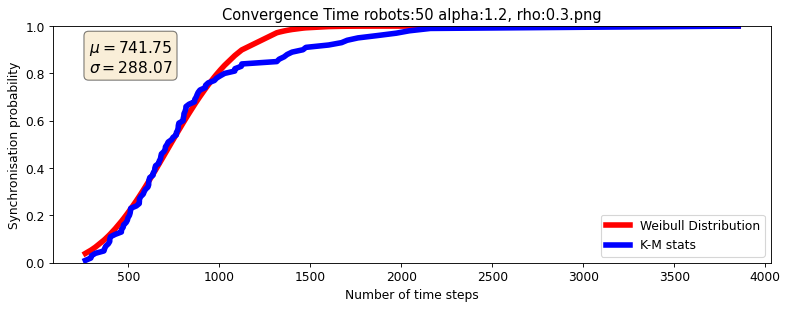

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.4_rho_0.9.png


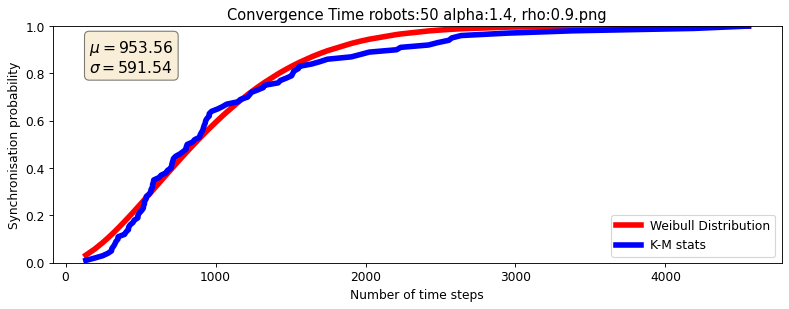

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.6_rho_0.9.png


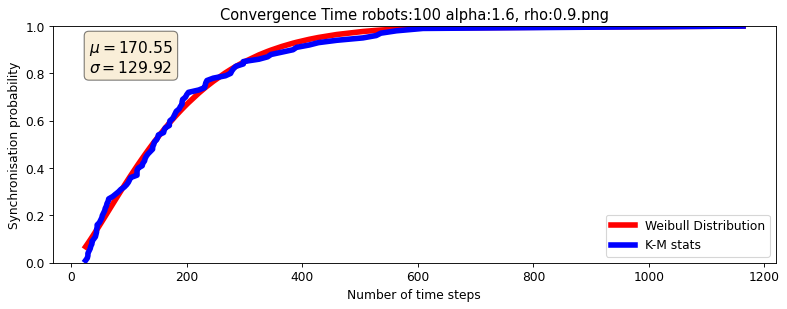

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.6_rho_0.0.png


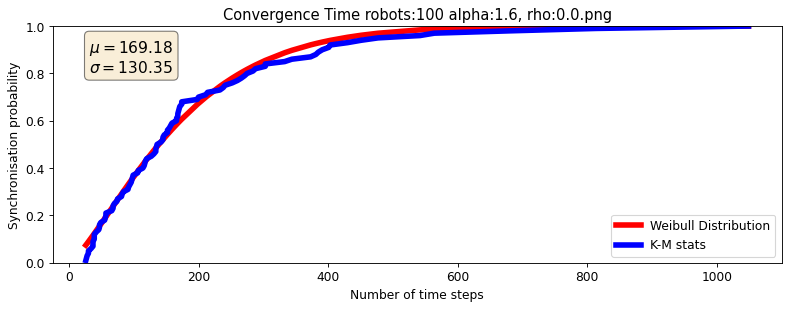

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.2_rho_0.6.png


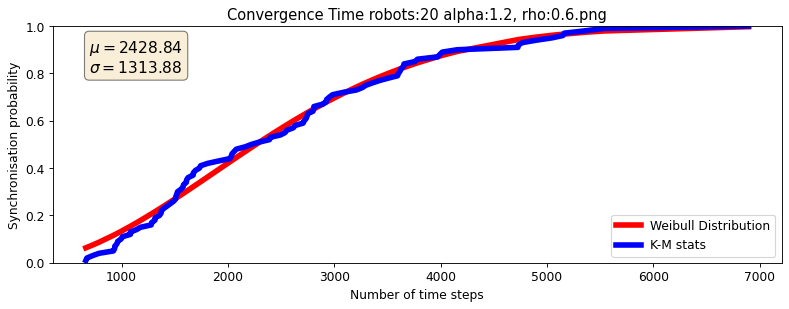

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.3_1800
num_robots 100, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_2.0_rho_0.3.png


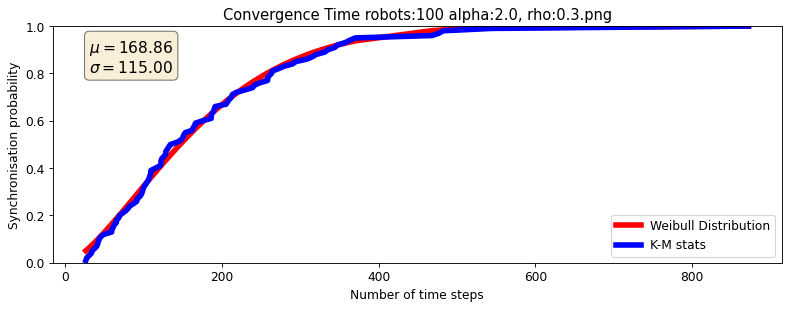

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.8_rho_0.9.png


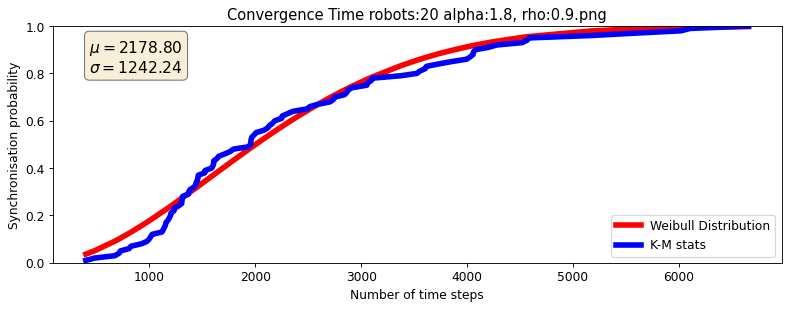

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.6_1800
num_robots 50, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_2.0_rho_0.6.png


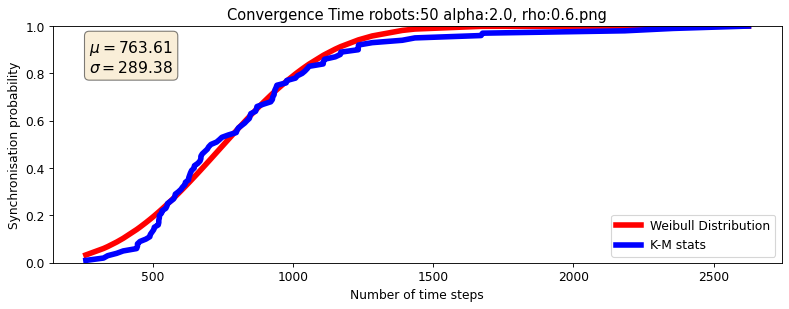

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.6_rho_0.0.png


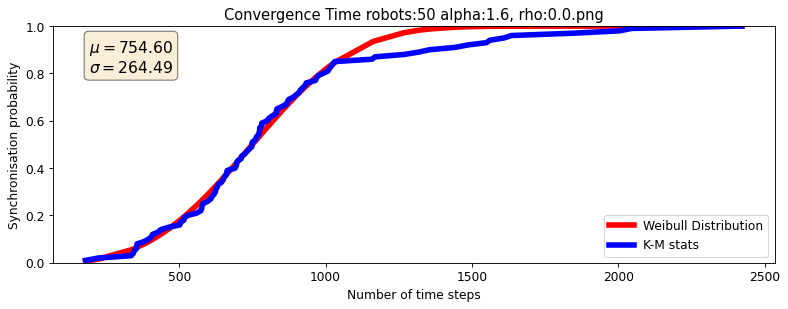

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.2_rho_0.9.png


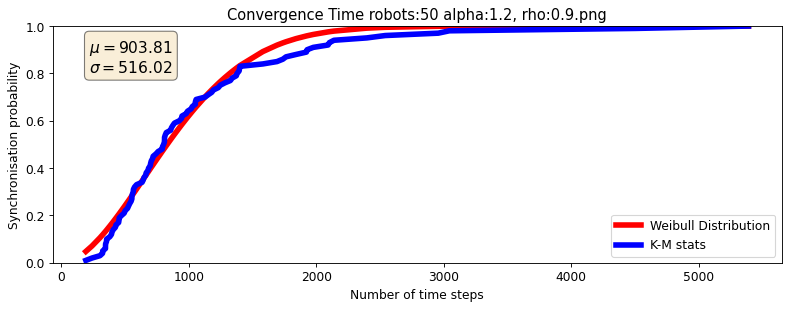

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.9_1800
num_robots 100, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_2.0_rho_0.9.png


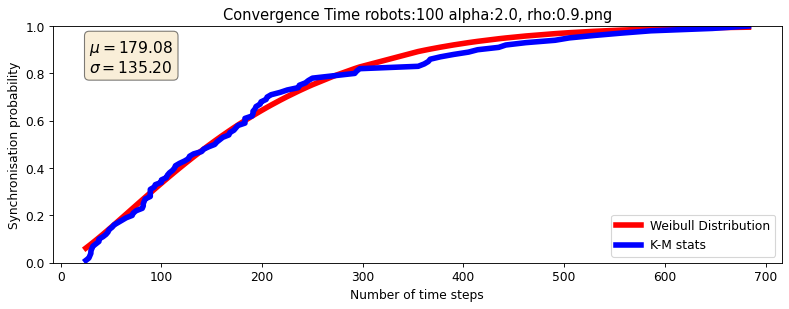

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.8_rho_0.0.png


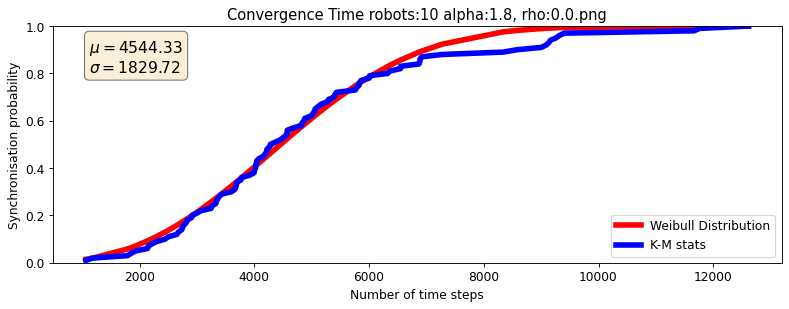

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.4_rho_0.0.png


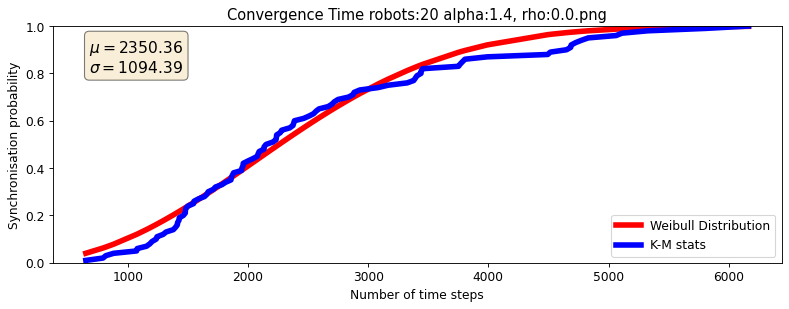

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.4_rho_0.9.png


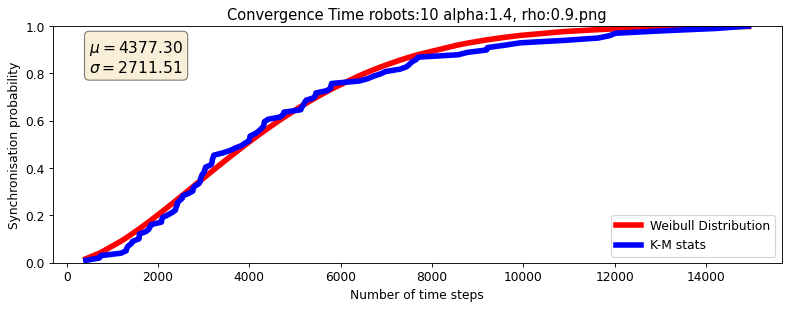

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.2_rho_0.9.png


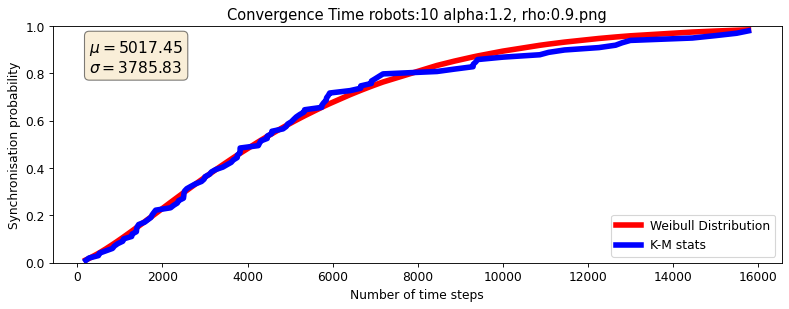

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.4_rho_0.0.png


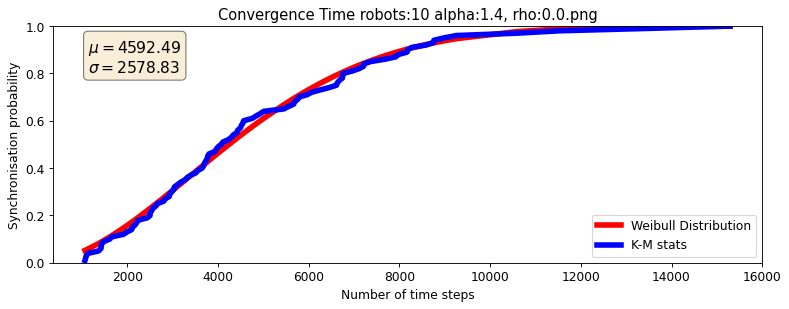

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.0_1800
num_robots 10, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_2.0_rho_0.0.png


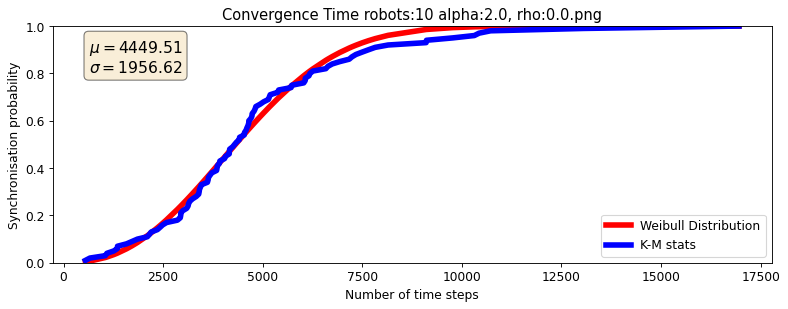

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.9_1800
num_robots 20, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_2.0_rho_0.9.png


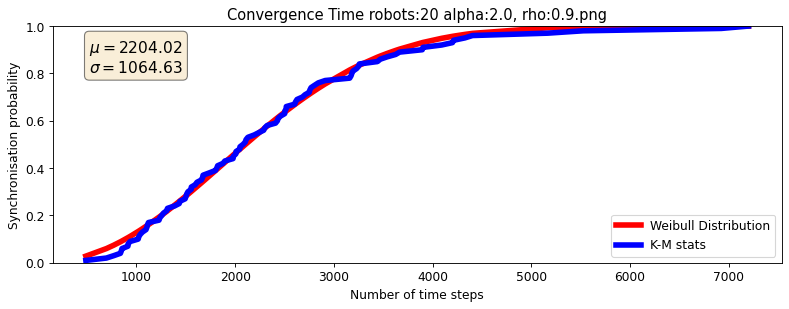

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.8_rho_0.0.png


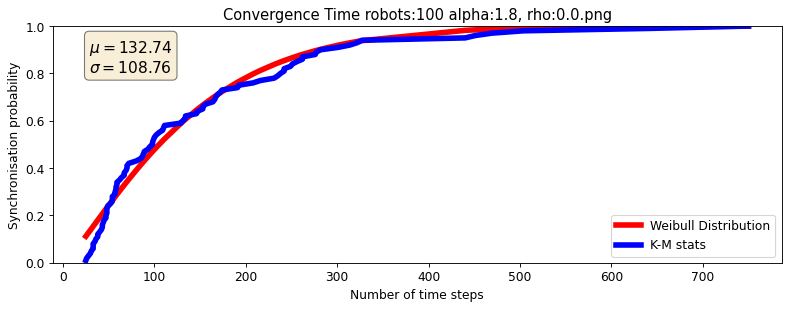

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.4_rho_0.9.png


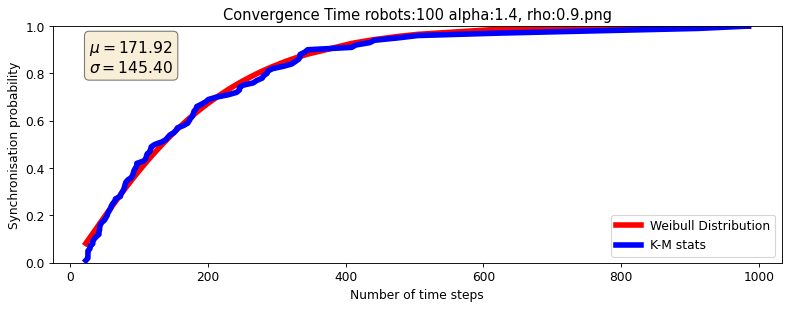

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_20_alpha_1.4_rho_0.9.png


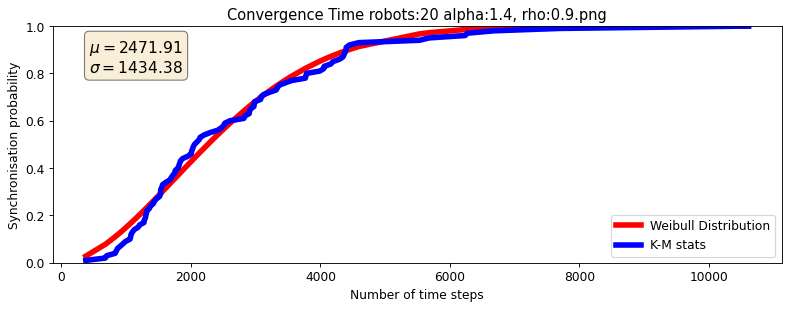

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.9_1800
num_robots 50, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_2.0_rho_0.9.png


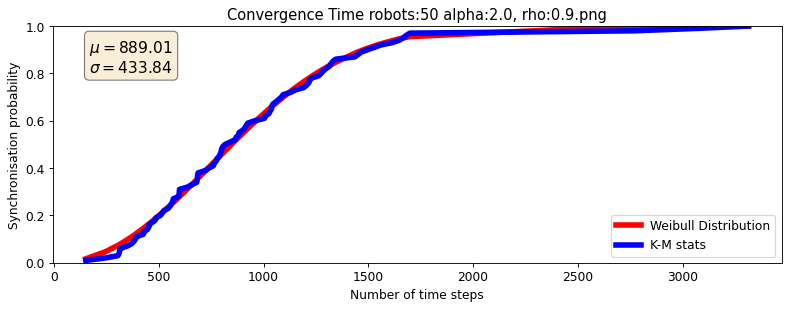

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_10_alpha_1.6_rho_0.6.png


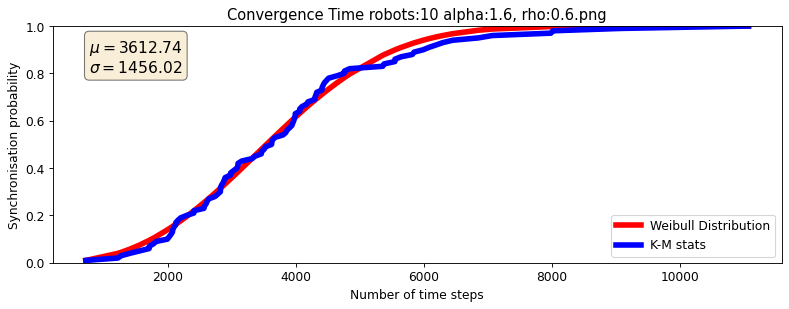

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_1.2_rho_0.0.png


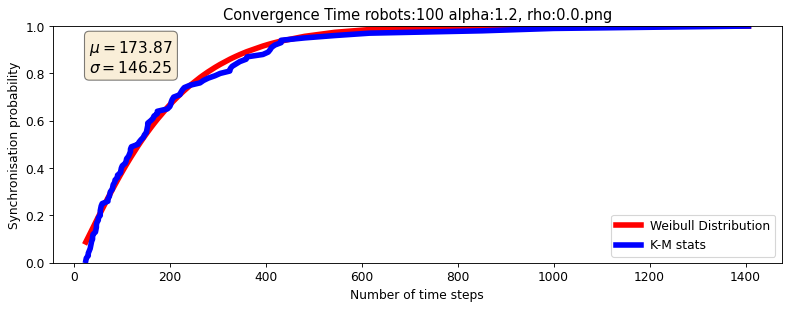

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.0_1800
num_robots 100, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_100_alpha_2.0_rho_0.0.png


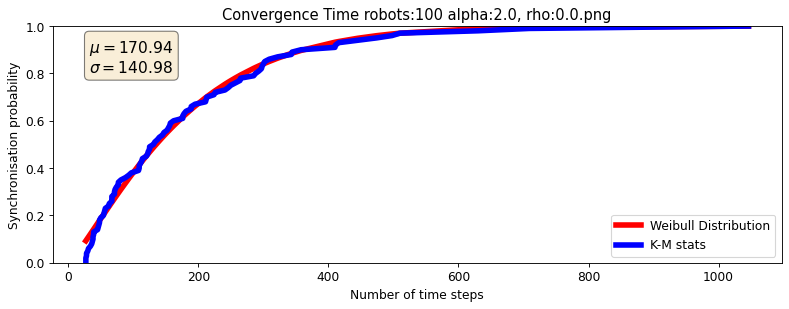

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_conv_time_robots_50_alpha_1.6_rho_0.6.png


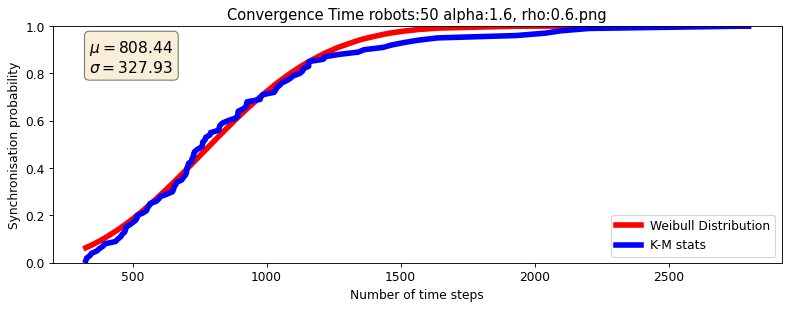

In [14]:
convergence_time_estimation = True   #if False ---> first passage time estimation

convergence_time_dict = dict()

print('Exp type: ', folder_experiments.split("/")[-1])
for dirName, subdirList, fileList in os.walk(os.path.join(main_folder,folder_experiments)):
    
    num_robots = "-1"
    rho = -1.0
    alpha = -1.0
    elements = dirName.split("/")[-1].split("_")
    if(folder_experiments.split("/")[-1] == 'Real'):
        extension = '.txt'
    else:
        extension = '.tsv'
#     print(colored("DirName:", 'blue'),dirName)
#     print(elements)
    for e in elements:
        if e.startswith("robots"):
            num_robots = e.split("#")[-1]
            if num_robots not in convergence_time_dict:
                convergence_time_dict[num_robots] = dict()

        if (e.startswith("rho")):
            if check_float(e.split("#")[-1]): rho = float(e.split("#")[-1])
        if (e.startswith("alpha")):
            if check_float(e.split("#")[-1]): alpha = float(e.split("#")[-1])
    
    if num_robots == "-1" or rho == -1.0 or alpha == -1:
        continue
    
    print(colored("DirName:", 'blue'),dirName)
    print('num_robots {}, rho {}, alpha {}'.format(num_robots, rho, alpha), end='\n\n')
        
        
    differentSeeds_convergenceTime = np.array([])
    
    for filename in fileList:
        if filename.endswith('time_results'+extension):
#             print('\t', filename)
            if not os.path.getsize(os.path.join(dirName, filename)) > 0:
                print("Error, empty file at:" + os.path.join(fileList, filename))
                continue
            
            if(folder_experiments.split("/")[-1] == 'Real'):
                df_single = pd.read_csv(os.path.join(dirName, filename), sep="\t", header=None)
            else:
                df_single = pd.read_csv(os.path.join(dirName, filename), sep="\t", header=None, skiprows=1)
            rho_str = str(rho)
            alpha_str = str(alpha)
            #     print("rho", rho_str)
            #     print("alpha", alpha_str)
            if rho_str not in convergence_time_dict[num_robots]:
                convergence_time_dict[num_robots][rho_str] = dict()
                
            np_times = df_single.to_numpy()[:,1:]
#             print(evaluate_convergence_time(np_times))
            differentSeeds_convergenceTime = np.row_stack([differentSeeds_convergenceTime, evaluate_convergence_time(np_times)]) if differentSeeds_convergenceTime.size else evaluate_convergence_time(np_times)
#             break
#             print('differentSeeds_convergenceTime.size {}'.format(differentSeeds_convergenceTime.size))

    '''**********************CONVERGENCE TIME**********************'''
    if convergence_time_estimation:
        convergenceTime = np.amax(differentSeeds_convergenceTime, axis=1)
        convergenceTime = convergenceTime[np.argsort(convergenceTime)]

        censored = convergenceTime.size - np.count_nonzero(convergenceTime)
#         print(convergenceTime)
        if censored:
            times_value = convergenceTime[censored:].reshape(-1)
        else:
            censored = 1
            times_value = convergenceTime.reshape(-1)

        F = KM_estimator(times_value, censored)

        # popt_weibull[0] is alpha
        # popt_weibull[1] is gamma
        if(folder_experiments.split("/")[-1] == 'Real'):
            bound_is = 500
        else:
            bound_is = 10000
        popt_weibull, _ = curve_fit(weib_cdf, xdata=times_value, ydata=np.squeeze(F), bounds=(0, [bound_is, 10]),
                                    method='trf')
        mean = sc.gamma(1 + (1. / popt_weibull[1])) * popt_weibull[0]
        #     print("mean",mean)
        std_dev = np.sqrt(popt_weibull[0] ** 2 * sc.gamma(1 + (2. / popt_weibull[1])) - mean ** 2)

        std_error = std_dev / np.sqrt(times_value.size)
        convergence_time_dict[num_robots][rho_str][alpha_str] = mean
        #     print(times_value.shape)

        figLabel = "Convergence Time robots:%s alpha:%s, rho:%s.png" % (num_robots, alpha_str, rho_str)
        figName = folder_experiments.split("/")[-1]+'_conv_time_robots_%s_alpha_%s_rho_%s.png' % (num_robots, alpha_str, rho_str)
        weibull_plot(mean, std_dev, times_value, popt_weibull, F, figLabel, figName, convergence_time_estimation) 

Exp type:  simple_experiment_100_runs
DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.8_rho_0.9.png


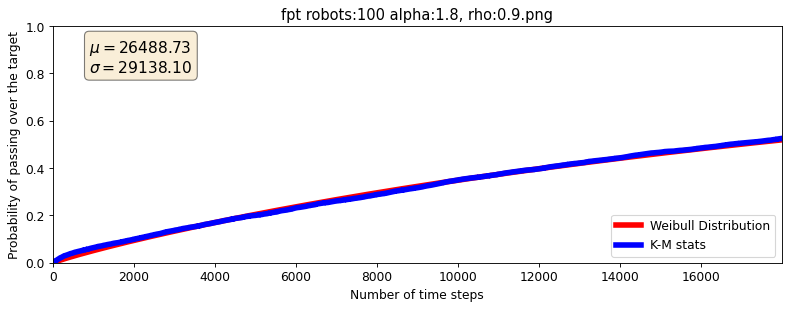

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.8_rho_0.9.png


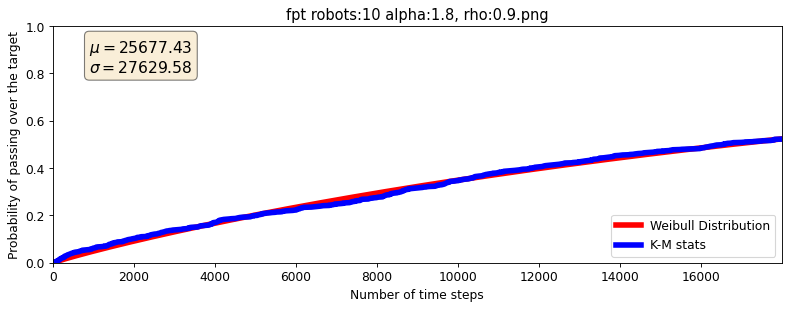

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.6_rho_0.3.png


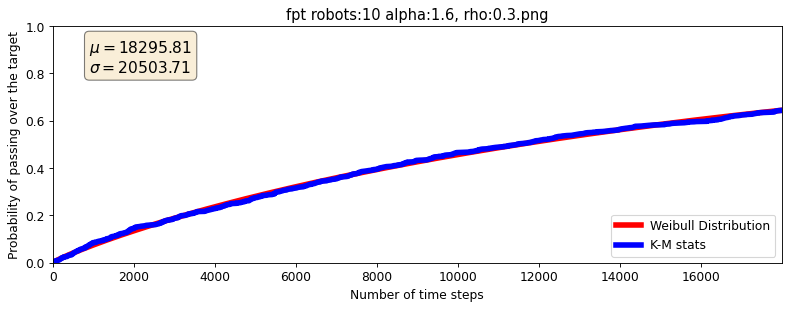

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.6_rho_0.6.png


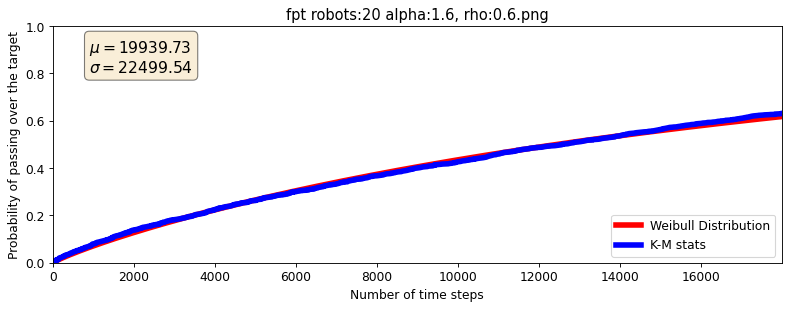

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.3_1800
num_robots 10, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_2.0_rho_0.3.png


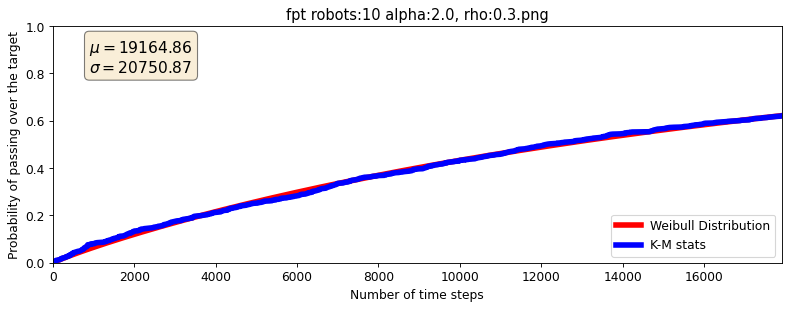

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.3_1800
num_robots 50, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_2.0_rho_0.3.png


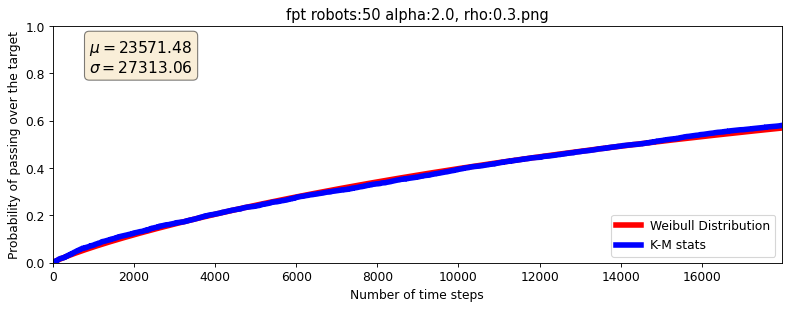

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.4_rho_0.6.png


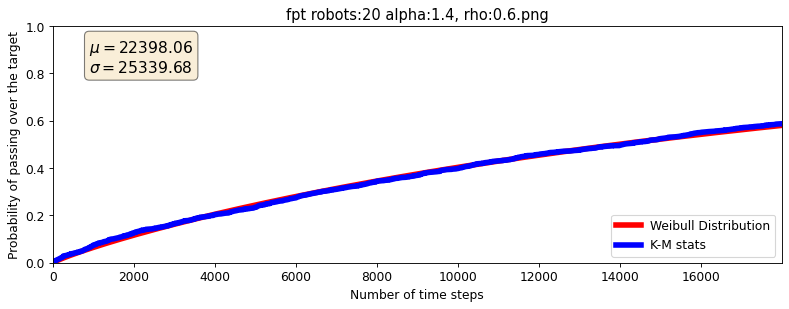

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.8_rho_0.3.png


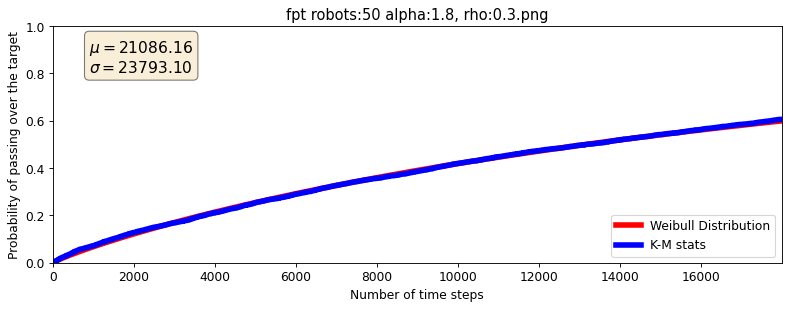

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.2_rho_0.0.png


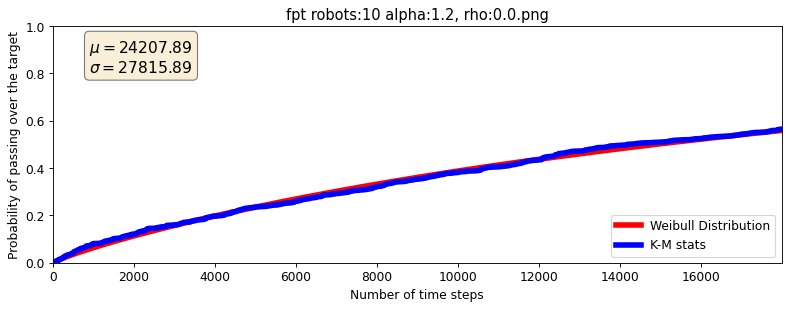

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.3_1800
num_robots 20, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_2.0_rho_0.3.png


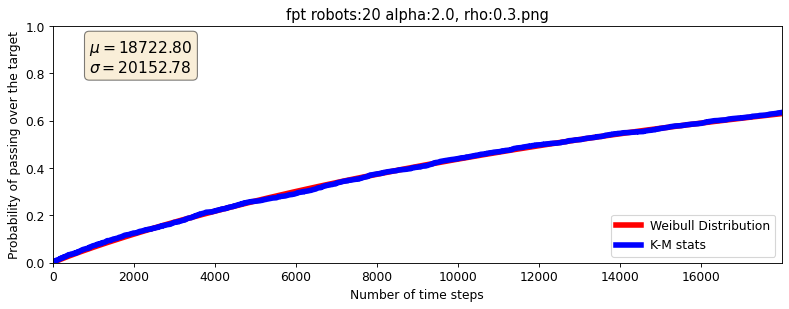

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.8_rho_0.3.png


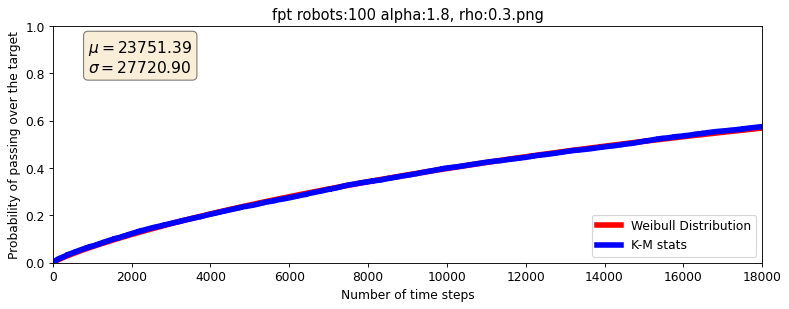

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.8_rho_0.6.png


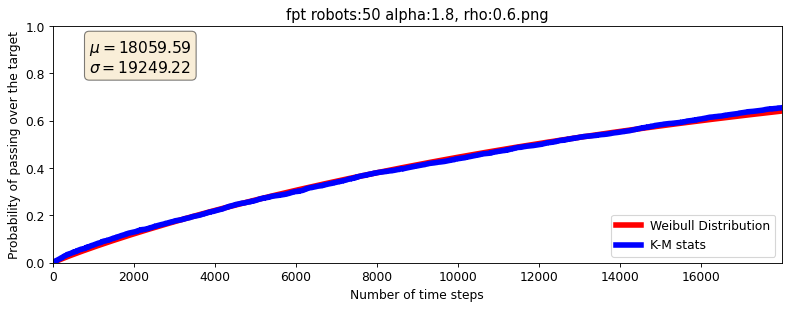

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.2_rho_0.0.png


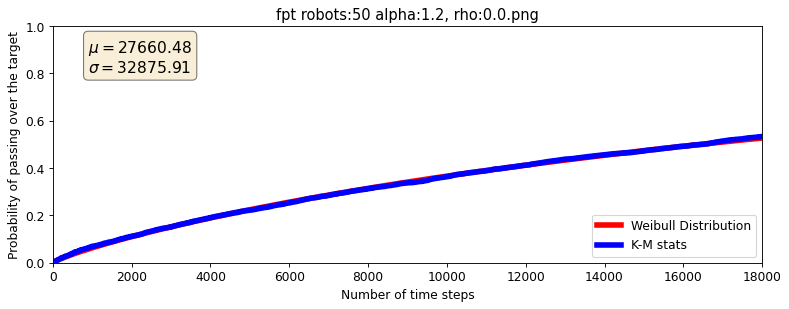

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.2_rho_0.3.png


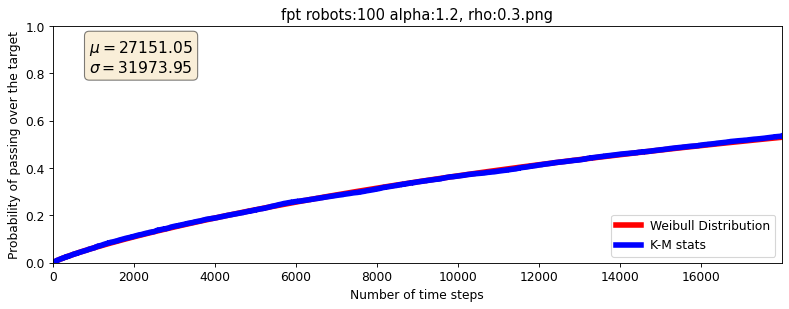

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.4_rho_0.3.png


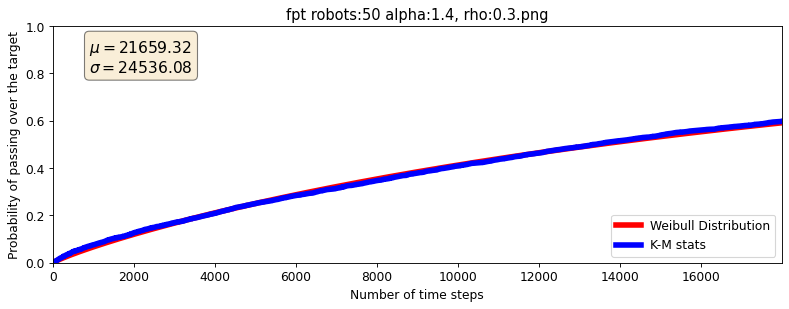

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.6_1800
num_robots 20, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_2.0_rho_0.6.png


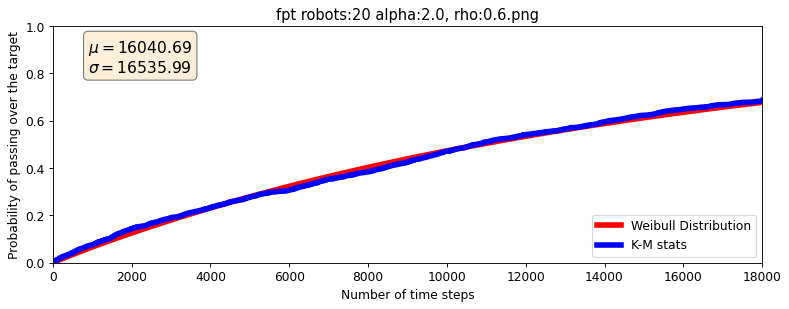

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.4_rho_0.0.png


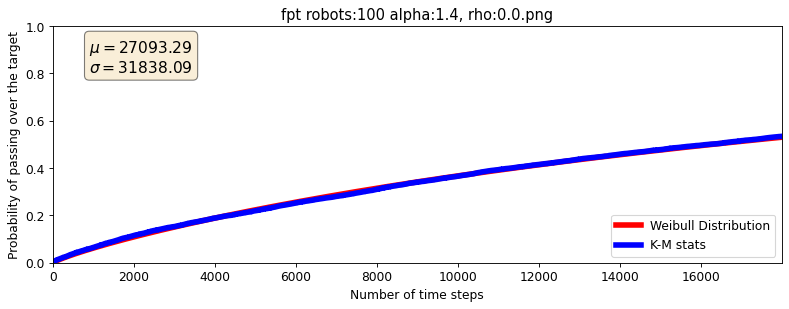

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.2_rho_0.3.png


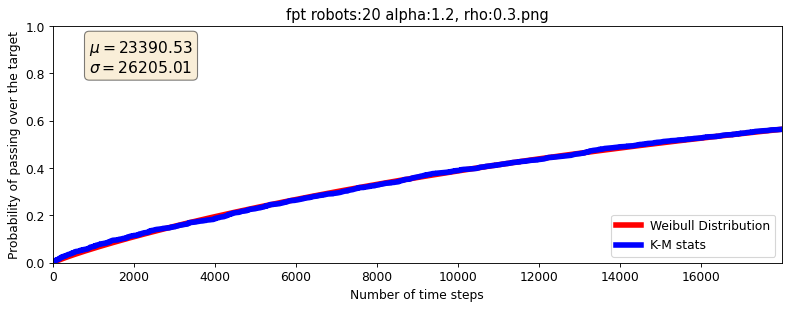

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.8_rho_0.9.png


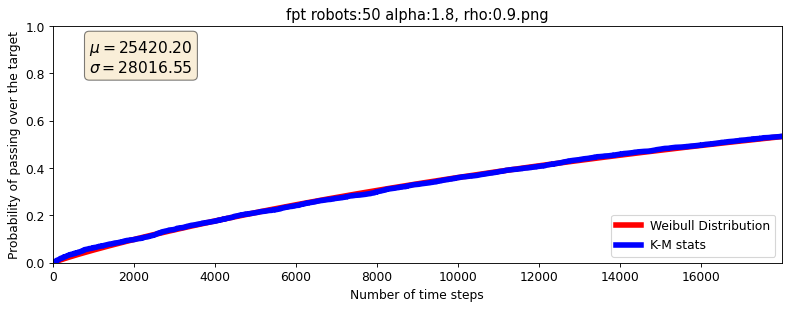

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.6_rho_0.3.png


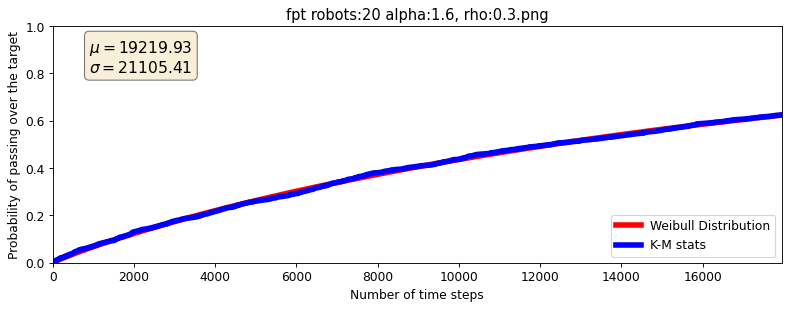

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.6_rho_0.9.png


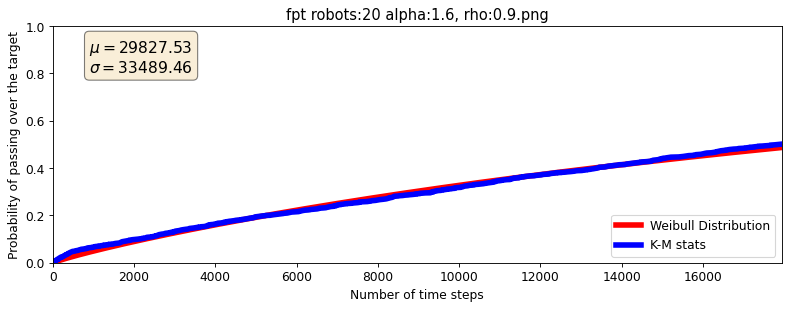

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.8_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.8_rho_0.0.png


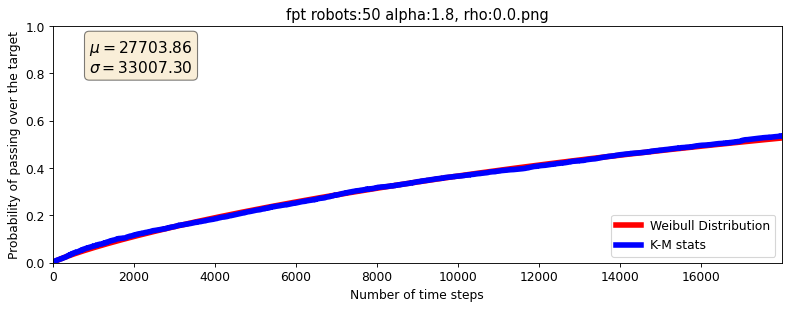

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.4_rho_0.6.png


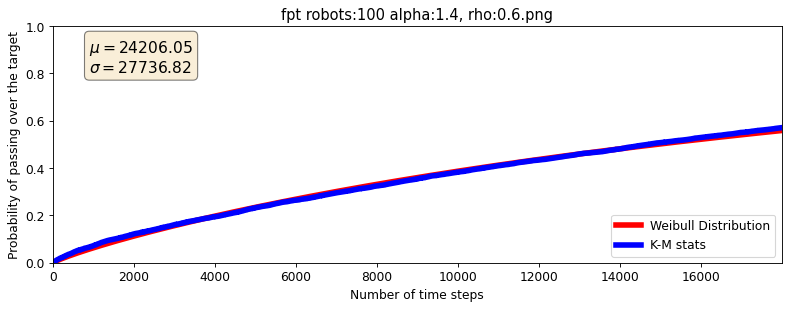

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.8_rho_0.3.png


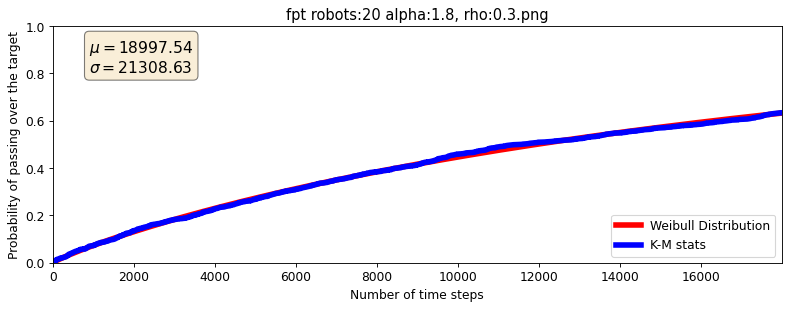

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.6_rho_0.9.png


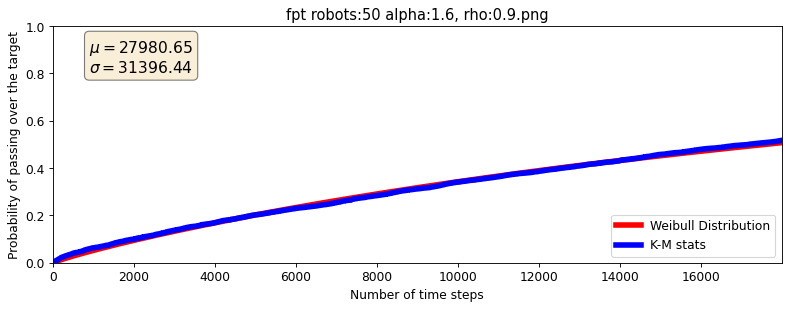

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.8_rho_0.6.png


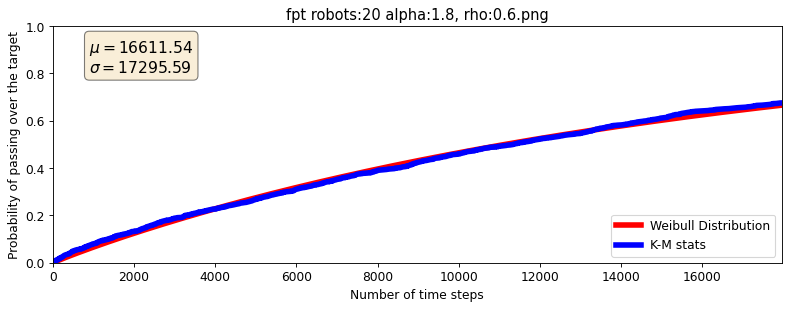

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.8_rho_0.6.png


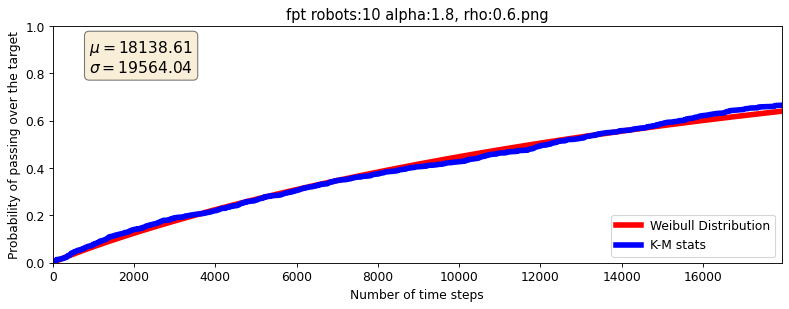

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.6_rho_0.0.png


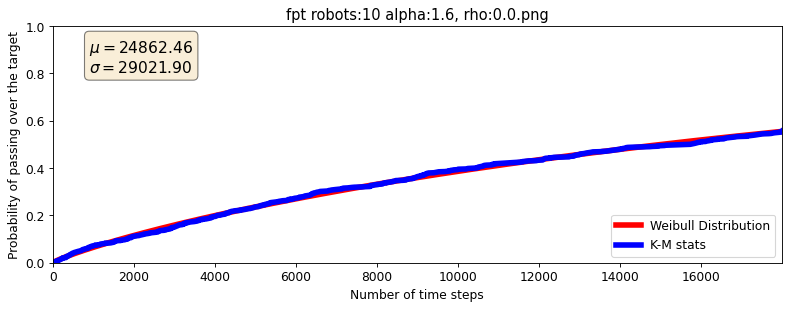

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.2_rho_0.9.png


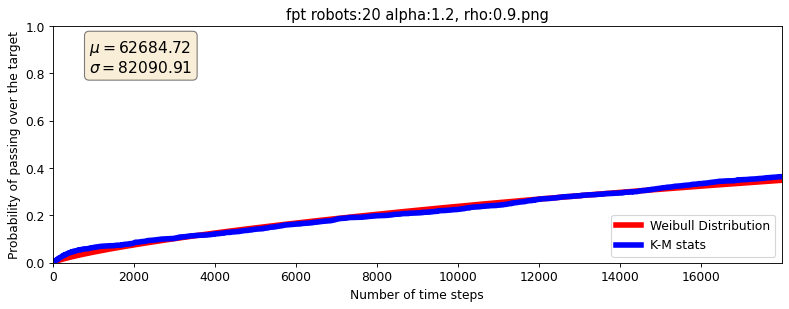

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.8_rho_0.0.png


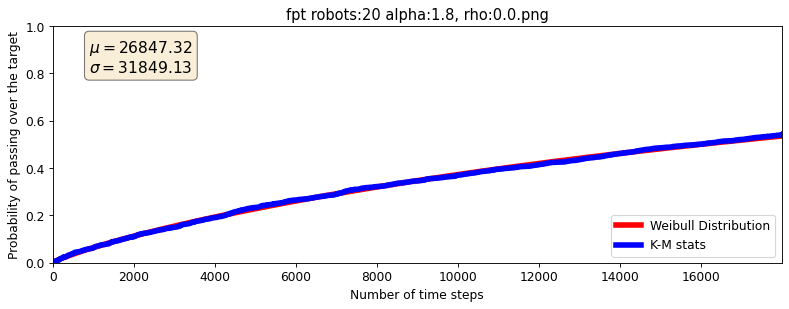

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.2_rho_0.0.png


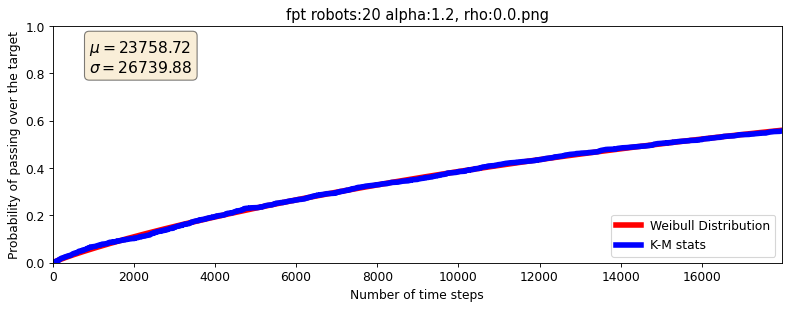

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.8_rho_0.6.png


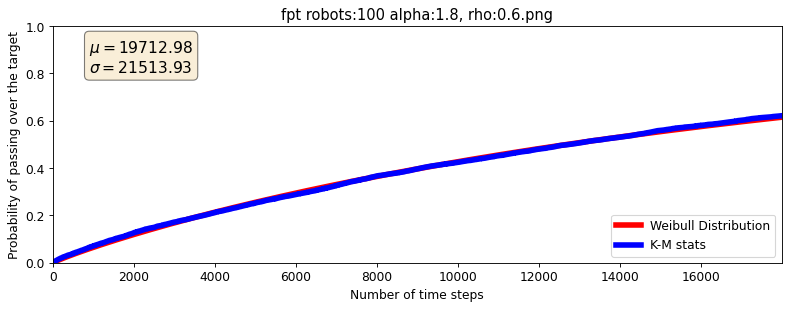

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.2_rho_0.9.png


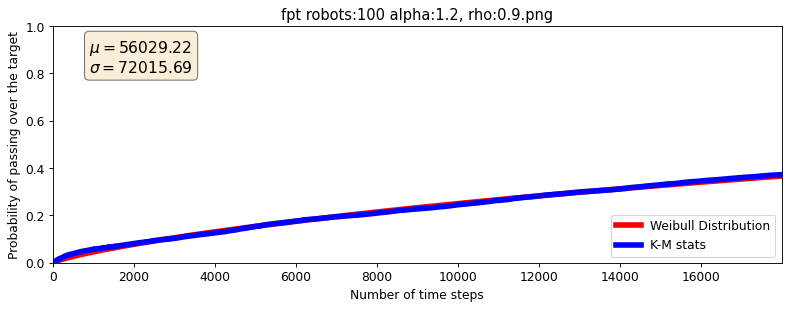

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.4_rho_0.3.png


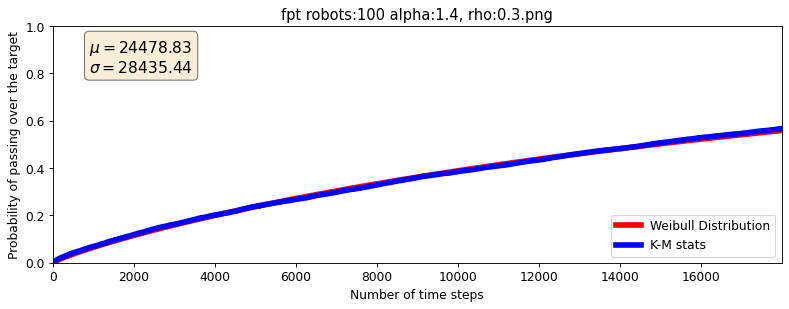

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.4_rho_0.0.png


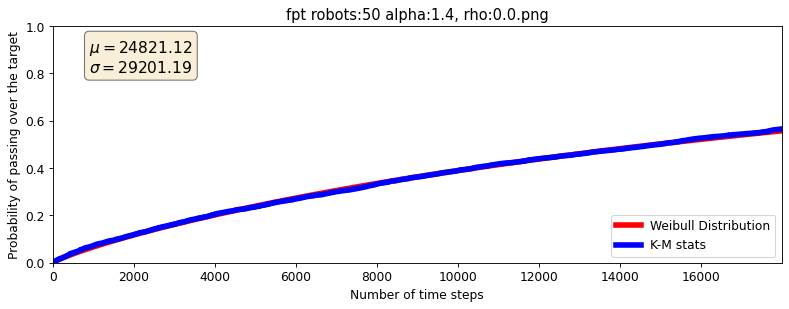

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.9_1800
num_robots 10, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_2.0_rho_0.9.png


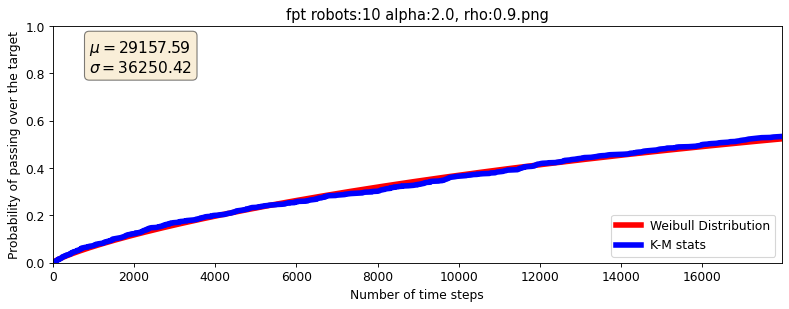

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.6_rho_0.3.png


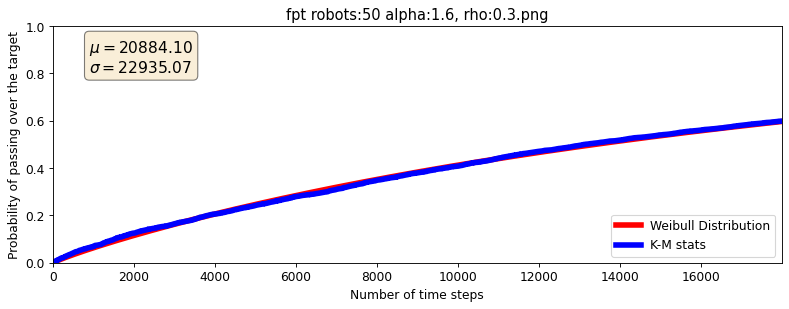

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.6_1800
num_robots 10, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_2.0_rho_0.6.png


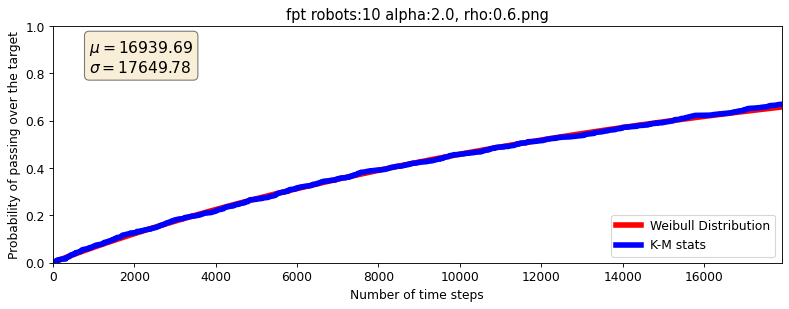

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.2_rho_0.6.png


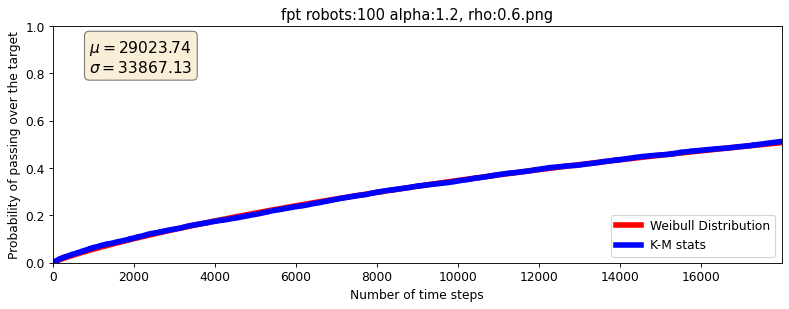

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.4_rho_0.6.png


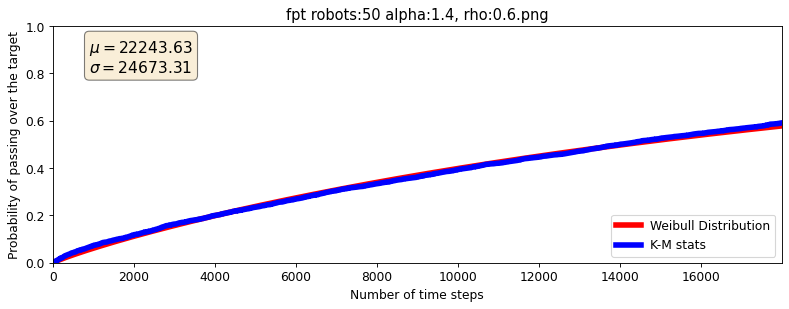

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.2_rho_0.3.png


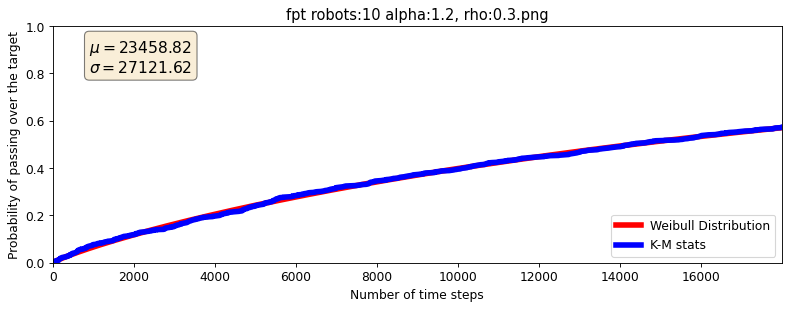

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.2_rho_0.6.png


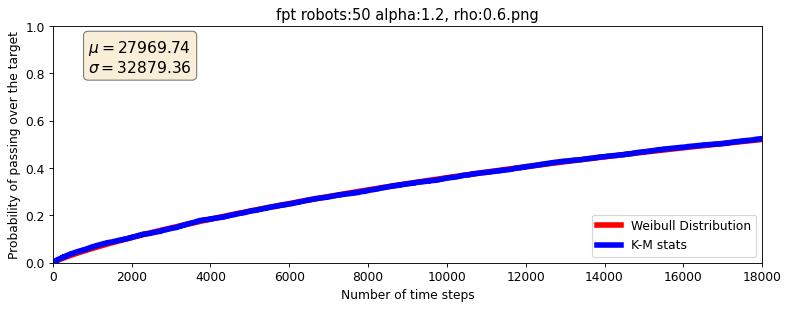

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.6_rho_0.9.png


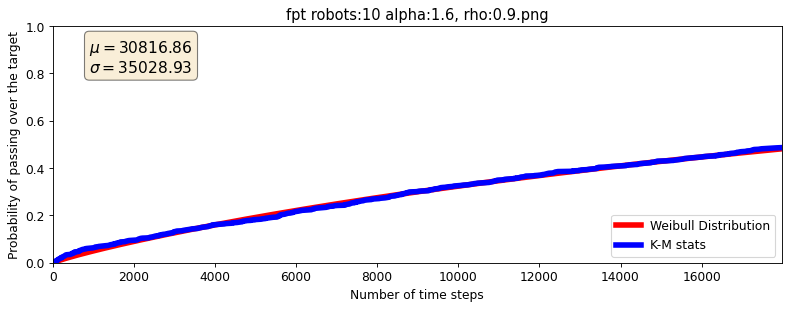

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.6_1800
num_robots 100, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.6_rho_0.6.png


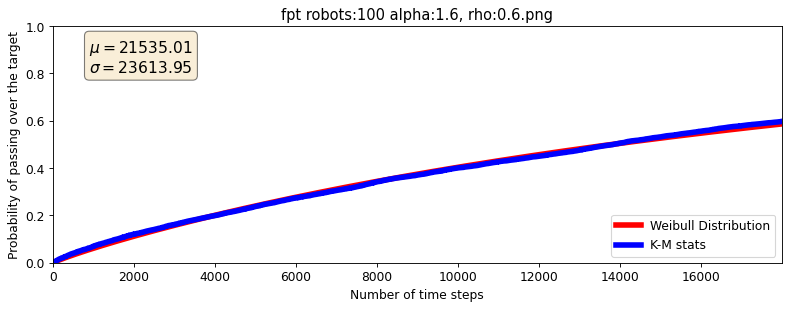

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.6_1800
num_robots 100, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_2.0_rho_0.6.png


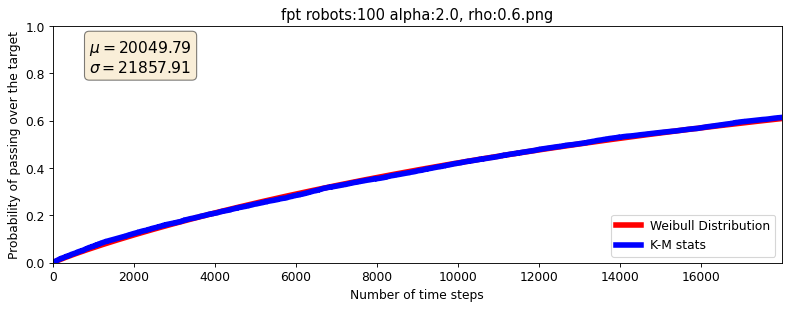

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.6_rho_0.0.png


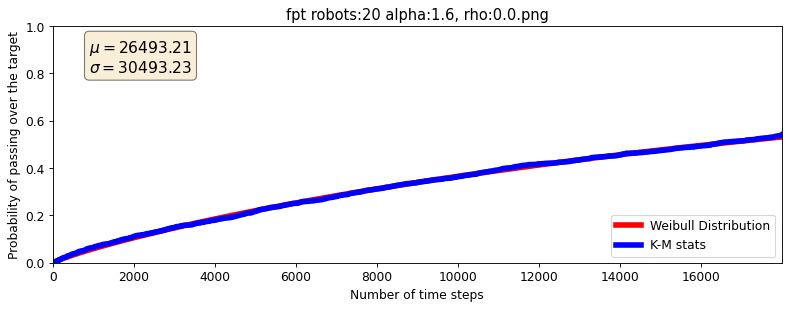

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.3_1800
num_robots 20, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.4_rho_0.3.png


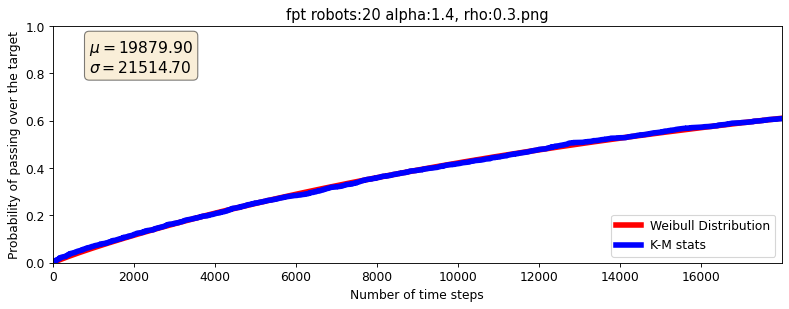

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.0_1800
num_robots 20, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_2.0_rho_0.0.png


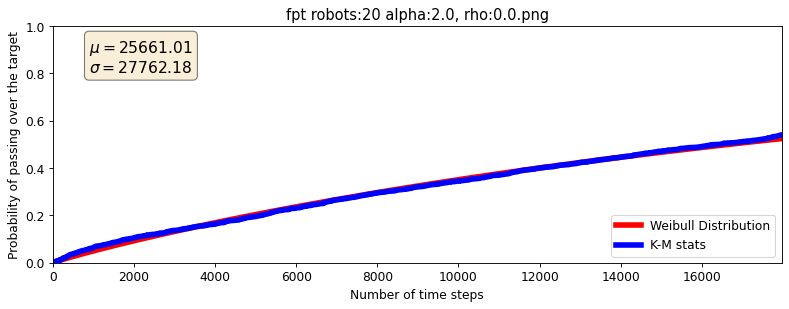

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.3_1800
num_robots 100, rho 0.3, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.6_rho_0.3.png


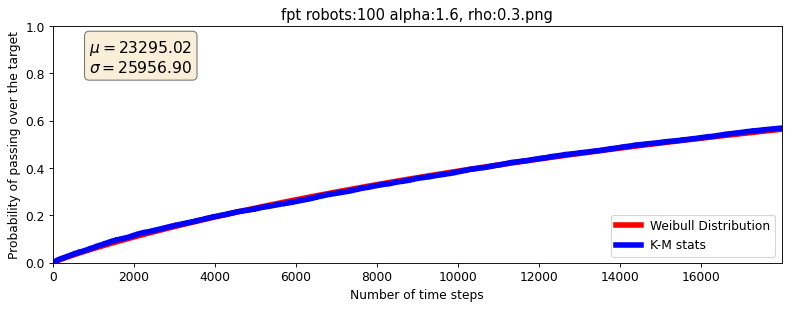

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.4_rho_0.3.png


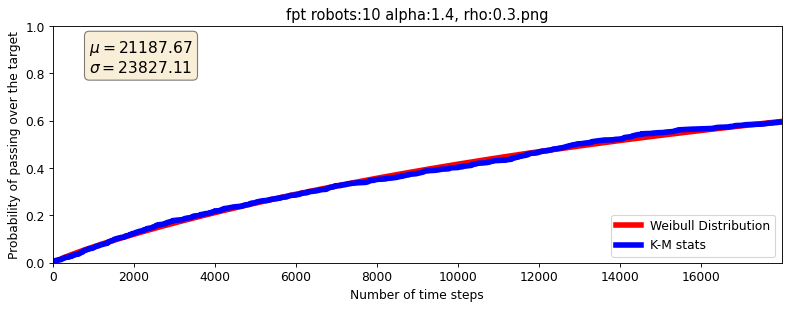

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.3_1800
num_robots 10, rho 0.3, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.8_rho_0.3.png


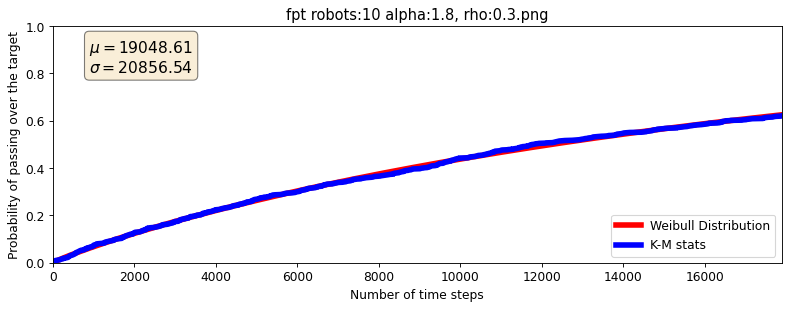

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.0_1800
num_robots 50, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_2.0_rho_0.0.png


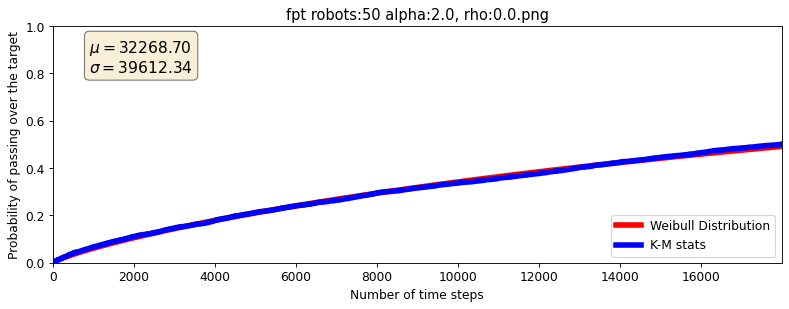

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.4_rho_0.6.png


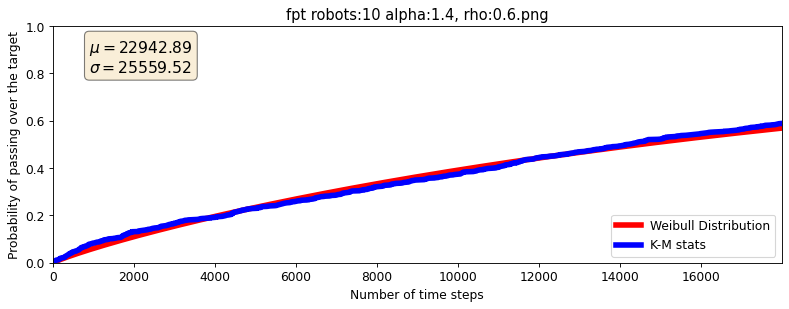

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.2_rho_0.6.png


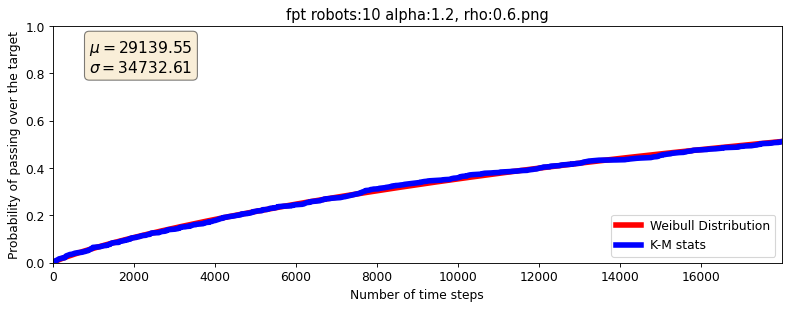

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.3_1800
num_robots 50, rho 0.3, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.2_rho_0.3.png


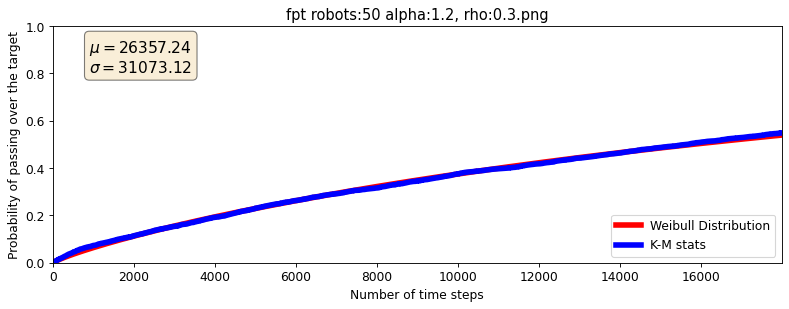

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#50_alpha#1.4_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.4_rho_0.9.png


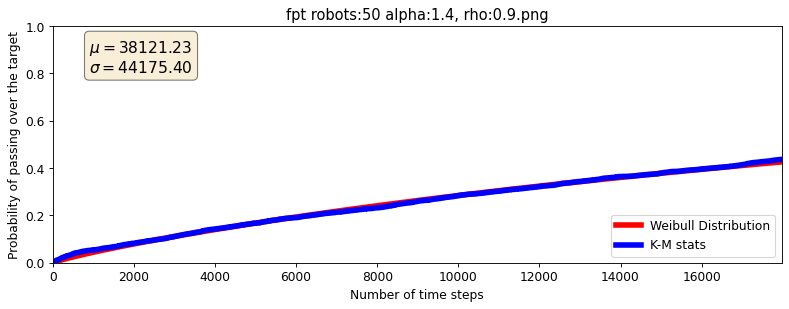

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.6_rho_0.9.png


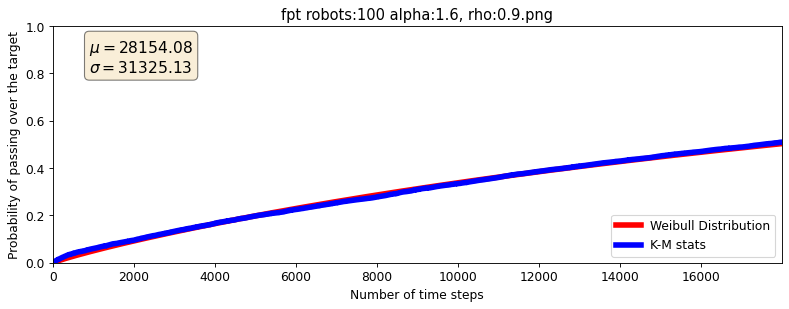

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.6_rho_0.0.png


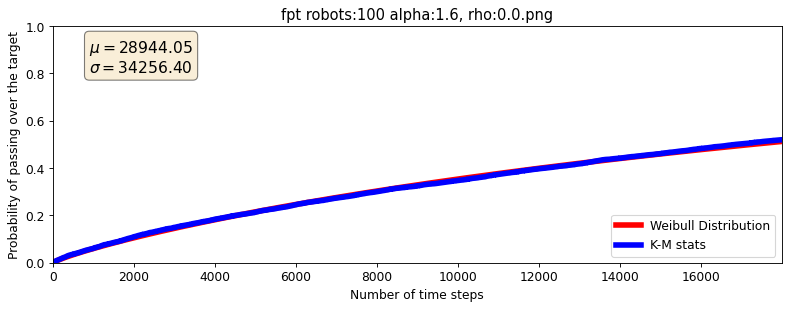

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.6_1800
num_robots 20, rho 0.6, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.2_rho_0.6.png


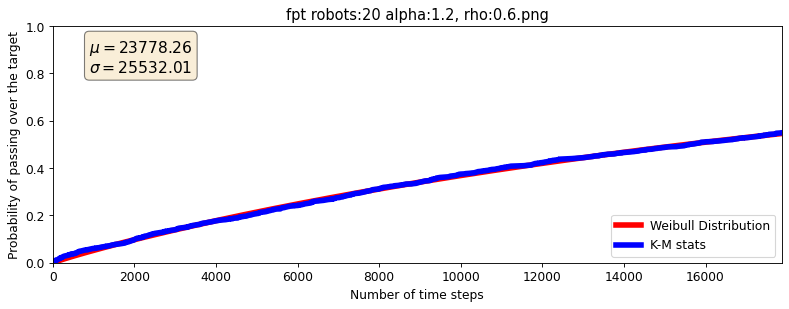

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.3_1800
num_robots 100, rho 0.3, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_2.0_rho_0.3.png


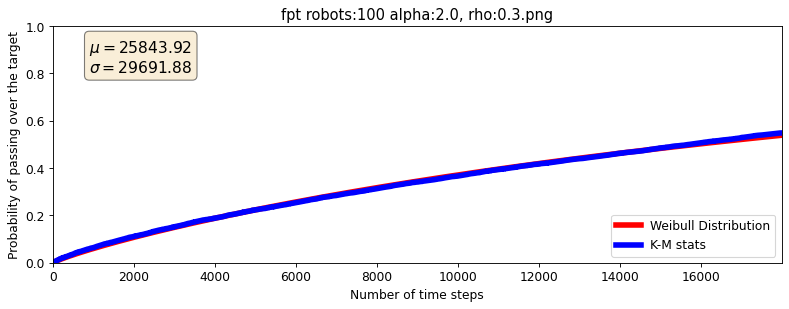

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.8_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.8_rho_0.9.png


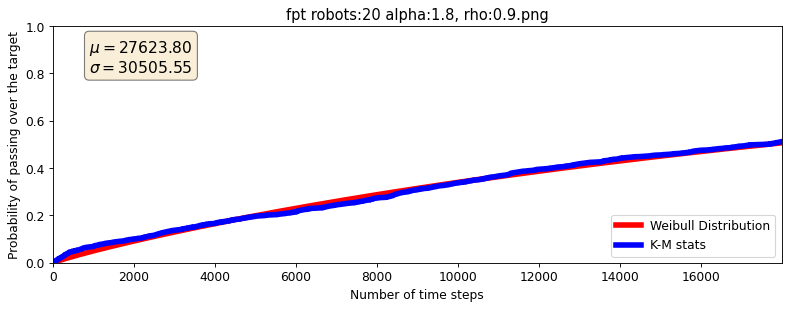

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.6_1800
num_robots 50, rho 0.6, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_2.0_rho_0.6.png


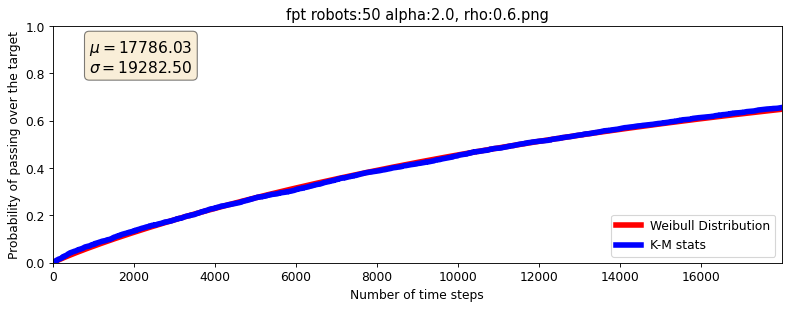

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.0_1800
num_robots 50, rho 0.0, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.6_rho_0.0.png


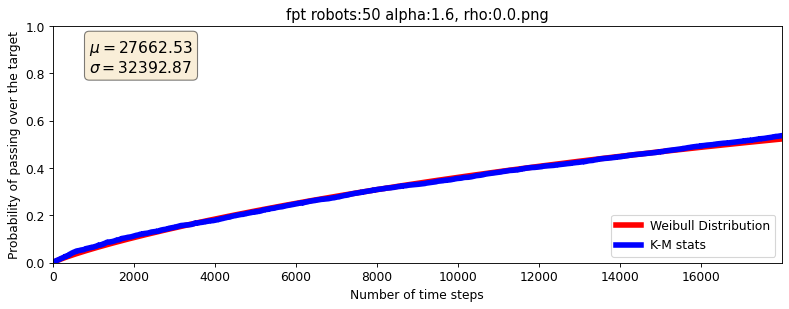

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.9_1800
num_robots 50, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.2_rho_0.9.png


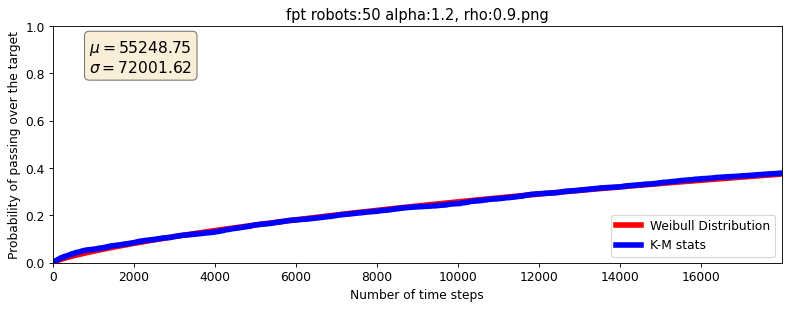

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.9_1800
num_robots 100, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_2.0_rho_0.9.png


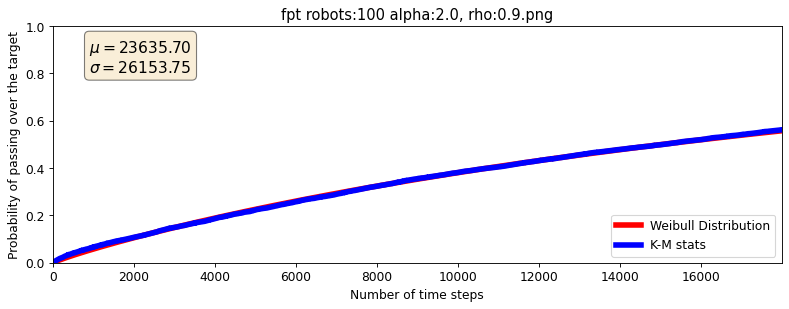

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.8_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.8_rho_0.0.png


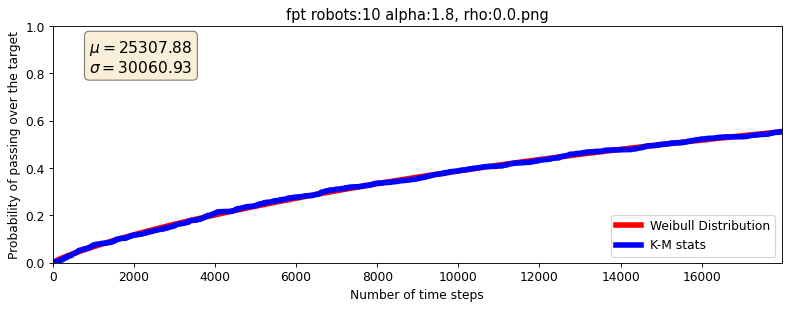

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.0_1800
num_robots 20, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.4_rho_0.0.png


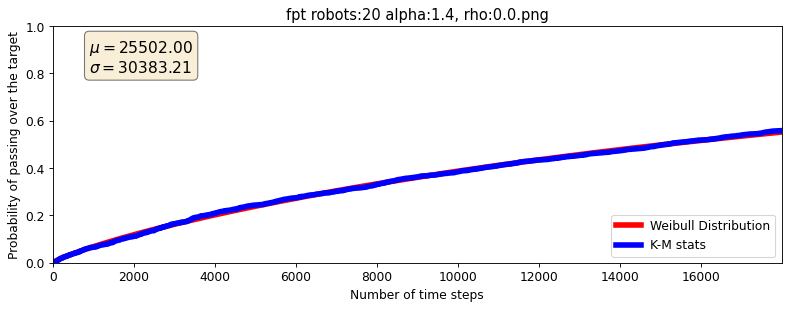

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.4_rho_0.9.png


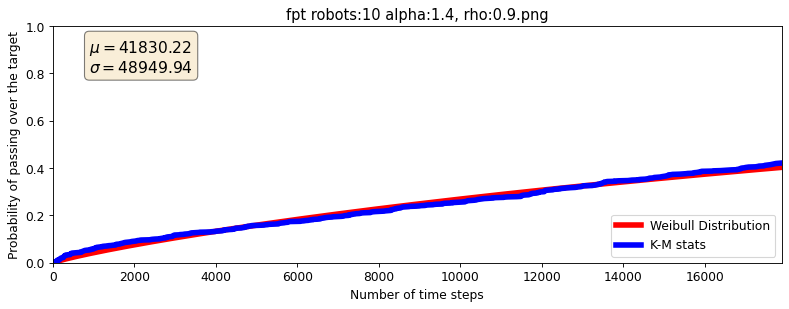

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.9_1800
num_robots 10, rho 0.9, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.2_rho_0.9.png


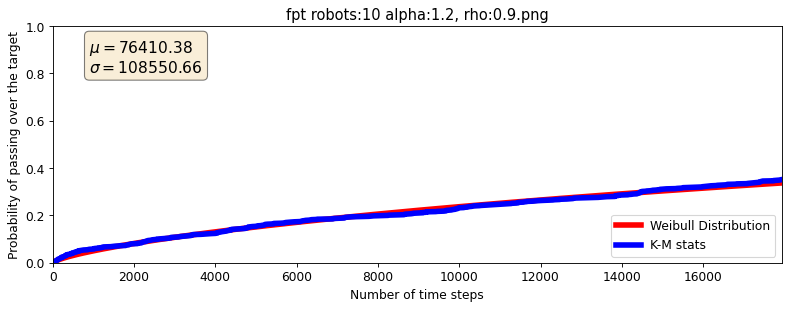

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#10_alpha#1.4_rho#0.0_1800
num_robots 10, rho 0.0, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.4_rho_0.0.png


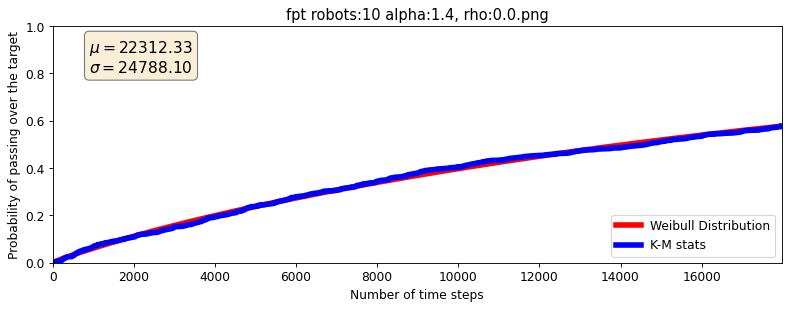

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.0_1800
num_robots 10, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_2.0_rho_0.0.png


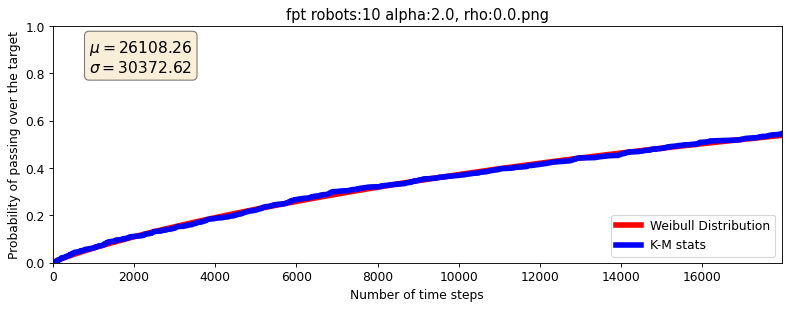

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.9_1800
num_robots 20, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_2.0_rho_0.9.png


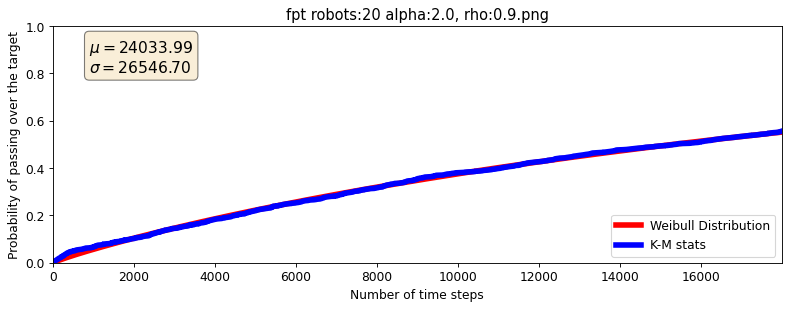

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.8_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.8

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.8_rho_0.0.png


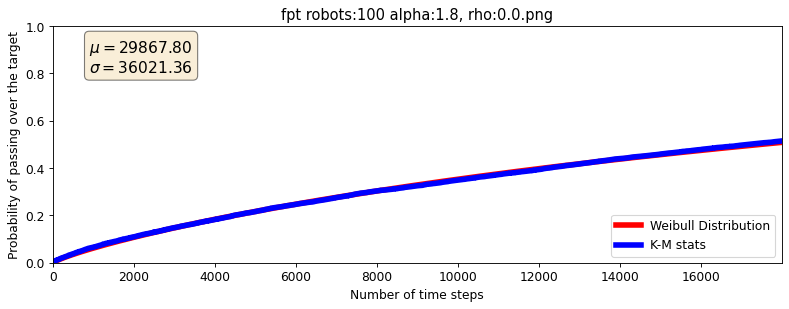

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-22_robots#100_alpha#1.4_rho#0.9_1800
num_robots 100, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.4_rho_0.9.png


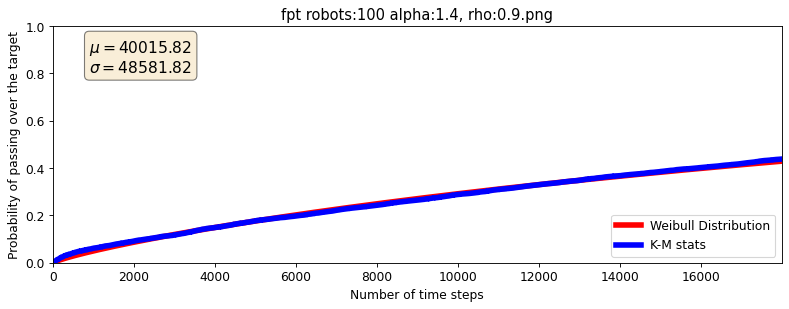

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2021-09-20_robots#20_alpha#1.4_rho#0.9_1800
num_robots 20, rho 0.9, alpha 1.4

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_20_alpha_1.4_rho_0.9.png


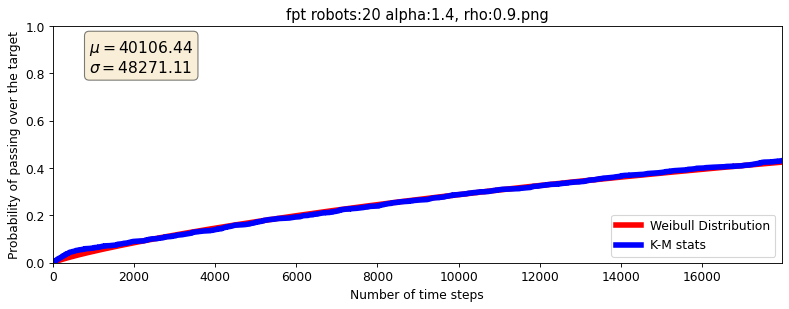

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.9_1800
num_robots 50, rho 0.9, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_2.0_rho_0.9.png


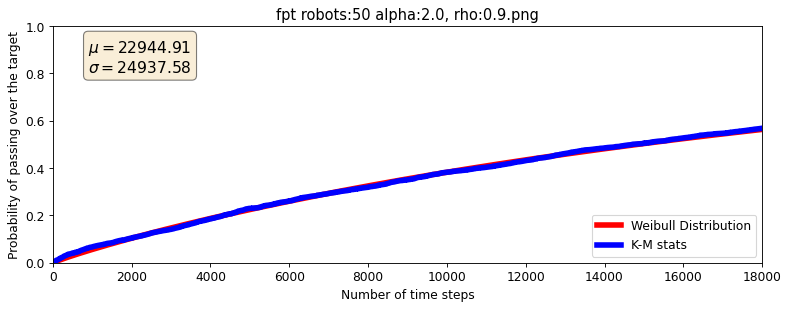

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.6_1800
num_robots 10, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_10_alpha_1.6_rho_0.6.png


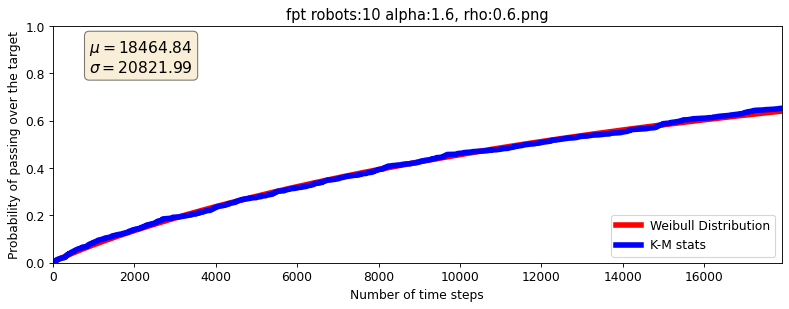

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.0_1800
num_robots 100, rho 0.0, alpha 1.2

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_1.2_rho_0.0.png


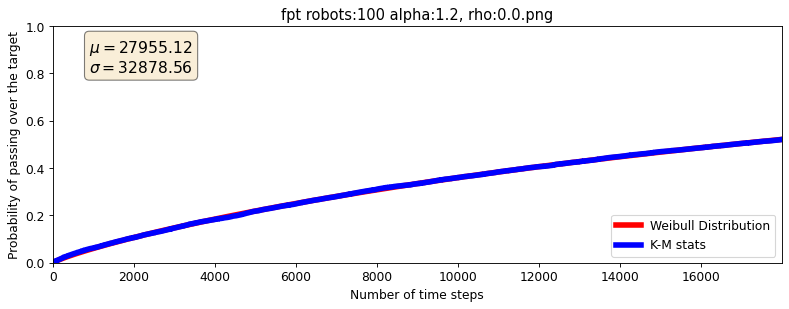

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.0_1800
num_robots 100, rho 0.0, alpha 2.0

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_100_alpha_2.0_rho_0.0.png


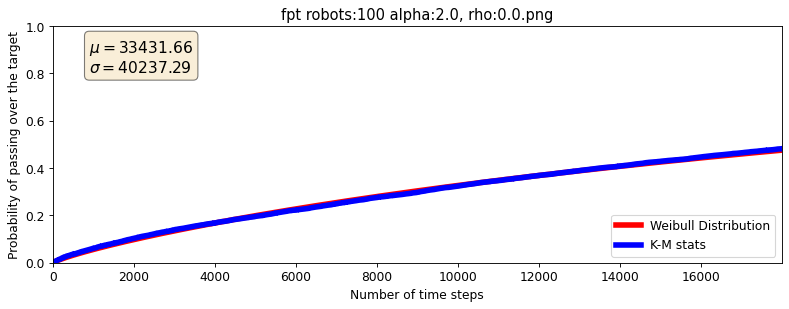

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/Simulated/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.6_1800
num_robots 50, rho 0.6, alpha 1.6

Saving fig at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_fpt_robots_50_alpha_1.6_rho_0.6.png


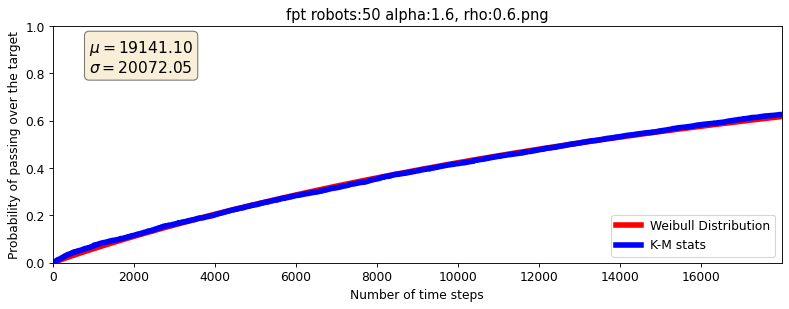

In [15]:
convergence_time_estimation = False   #if False ---> first passage time estimation

mean_fpt_dict = dict()

print('Exp type: ', folder_experiments.split("/")[-1])
for dirName, subdirList, fileList in os.walk(os.path.join(main_folder,folder_experiments)):
    
    num_robots = "-1"
    rho = -1.0
    alpha = -1.0
    elements = dirName.split("/")[-1].split("_")
    if(folder_experiments.split("/")[-1] == 'Real'):
        extension = '.txt'
    else:
        extension = '.tsv'
#     print(colored("DirName:", 'blue'),dirName)
#     print(elements)
    for e in elements:
        if e.startswith("robots"):
            num_robots = e.split("#")[-1]
            if num_robots not in mean_fpt_dict:
                mean_fpt_dict[num_robots] = dict()

        if (e.startswith("rho")):
            if check_float(e.split("#")[-1]): rho = float(e.split("#")[-1])
        if (e.startswith("alpha")):
            if check_float(e.split("#")[-1]): alpha = float(e.split("#")[-1])
    
    if num_robots == "-1" or rho == -1.0 or alpha == -1:
        continue
    
    print(colored("DirName:", 'blue'),dirName)
    print('num_robots {}, rho {}, alpha {}'.format(num_robots, rho, alpha), end='\n\n')
        
        
    differentSeeds_firstPassageTime = np.array([])
    
    for filename in fileList:
        if filename.endswith('time_results'+extension):
#             print('\t', filename)
            if not os.path.getsize(os.path.join(dirName, filename)) > 0:
                print("Error, empty file at:" + os.path.join(fileList, filename))
                continue
            
            if(folder_experiments.split("/")[-1] == 'Real'):
                df_single = pd.read_csv(os.path.join(dirName, filename), sep="\t", header=None)
            else:
                df_single = pd.read_csv(os.path.join(dirName, filename), sep="\t", header=None, skiprows=1)
            rho_str = str(rho)
            alpha_str = str(alpha)
            #     print("rho", rho_str)
            #     print("alpha", alpha_str)
            if rho_str not in mean_fpt_dict[num_robots]:
                mean_fpt_dict[num_robots][rho_str] = dict()
                
            np_times = df_single.to_numpy()[:,1:]
#             print(evaluate_convergence_time(np_times))
            
            differentSeeds_firstPassageTime = np.row_stack([differentSeeds_firstPassageTime, df_single.to_numpy()[:,1:2].reshape(-1)]) if differentSeeds_firstPassageTime.size else  df_single.to_numpy()[:,1:2].reshape(-1)
#             break
#             print('differentSeeds_convergenceTime.size {}'.format(differentSeeds_convergenceTime.size))
#             print('differentSeeds_firstPassageTime.size {}'.format(differentSeeds_firstPassageTime.size))

    '''**********************FIRST PASSAGE TIME**********************'''
    if not convergence_time_estimation:
        
        differentSeeds_firstPassageTime[differentSeeds_firstPassageTime < 0] = 0
        censored = differentSeeds_firstPassageTime.size - np.count_nonzero(differentSeeds_firstPassageTime)
        # print(differentSeeds_firstPassageTime)
        differentSeeds_firstPassageTime = differentSeeds_firstPassageTime.reshape(-1)
        fpt = differentSeeds_firstPassageTime[np.argsort(differentSeeds_firstPassageTime)]
        times_value = fpt[censored:].reshape(-1)
        F = KM_estimator(times_value, censored)


        
        if(folder_experiments.split("/")[-1] == 'Real'):
            bound_is = 7500
        else:
            bound_is = 75000
        popt_weibull, _ = curve_fit(weib_cdf, xdata=times_value, ydata=np.squeeze(F), bounds=(0, [bound_is, 10]), method='trf')
        mean = sc.gamma(1 + (1. / popt_weibull[1])) * popt_weibull[0]
        mean_fpt_dict[num_robots][rho_str][alpha_str] = mean
        #     print("mean",mean)
        std_dev = np.sqrt(popt_weibull[0] ** 2 * sc.gamma(1 + (2. / popt_weibull[1])) - mean ** 2)

        std_error = std_dev / np.sqrt(times_value.size)

        #     print(times_value.shape)
        figLabel = "fpt robots:%s alpha:%s, rho:%s.png" % (num_robots, alpha_str, rho_str)
        figName = folder_experiments.split("/")[-1]+'_fpt_robots_%s_alpha_%s_rho_%s.png' % (num_robots, alpha_str, rho_str)
        weibull_plot(mean, std_dev, times_value, popt_weibull, F, figLabel, figName, False)
        #             print(mean_fpt_dict, end="\n\n")
    
#     break

In [16]:
convergence_time_dict

{'100': {'0.9': {'1.8': 171.9386628057781,
   '1.2': 169.9709636199982,
   '1.6': 170.54833707334515,
   '2.0': 179.0765711436258,
   '1.4': 171.9193839233588},
  '0.3': {'1.8': 132.11686192227359,
   '1.2': 179.68298603771265,
   '1.4': 137.00615853236536,
   '1.6': 173.23619013328923,
   '2.0': 168.863540153141},
  '0.0': {'1.4': 139.6432999946406,
   '1.6': 169.18368921199877,
   '1.8': 132.73522563865157,
   '1.2': 173.872083174864,
   '2.0': 170.9419792848811},
  '0.6': {'1.4': 152.22658776465127,
   '1.8': 153.31955854502232,
   '1.2': 190.50692798087928,
   '1.6': 187.18069121383039,
   '2.0': 185.51145858728702}},
 '10': {'0.9': {'1.8': 4015.90571816677,
   '2.0': 3434.707250936011,
   '1.6': 4006.6309761274206,
   '1.4': 4377.299770807691,
   '1.2': 5017.451429628544},
  '0.3': {'1.6': 4237.697142764633,
   '2.0': 4331.515498008541,
   '1.2': 3924.365448573898,
   '1.4': 3992.1738261724895,
   '1.8': 4310.328364346706},
  '0.0': {'1.2': 3960.2350386239536,
   '1.6': 4495.01110

In [17]:
mean_ct_dict = convergence_time_dict

In [18]:
# to_pkl(mean_fpt_dict, 'mean_fpt_dict')
# to_pkl(mean_ct_dict, 'mean_ct_dict')

In [19]:
ct_dict = sort_nested_dict(mean_ct_dict)
fpt_dict = sort_nested_dict(mean_fpt_dict)

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_Convergence Time_10_robots.png


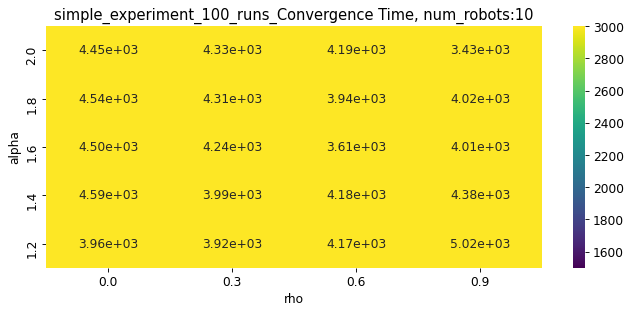

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_Convergence Time_100_robots.png


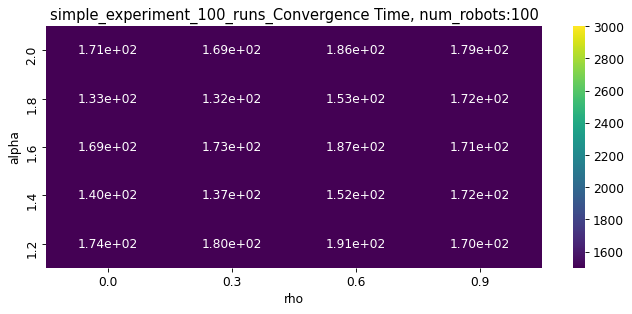

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_Convergence Time_20_robots.png


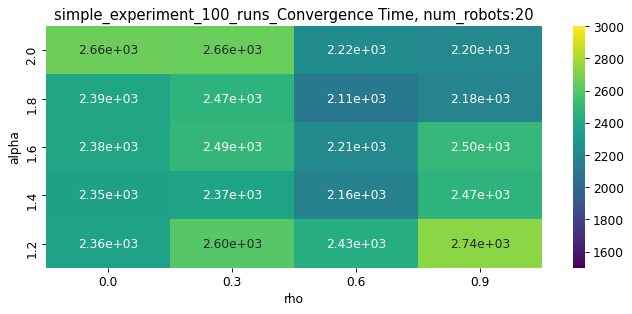

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_Convergence Time_50_robots.png


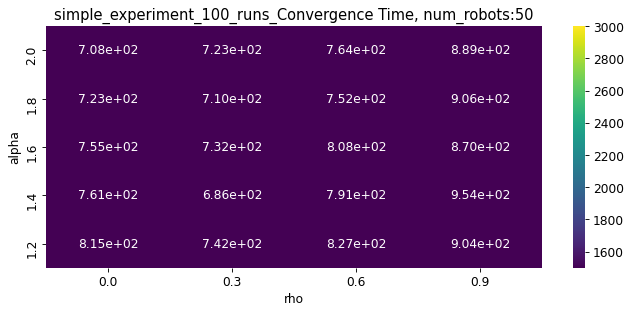

In [20]:
plot_heatmap(ct_dict, folder_experiments.split("/")[-1]+'_Convergence Time', True)

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_First passage Time_10_robots.png


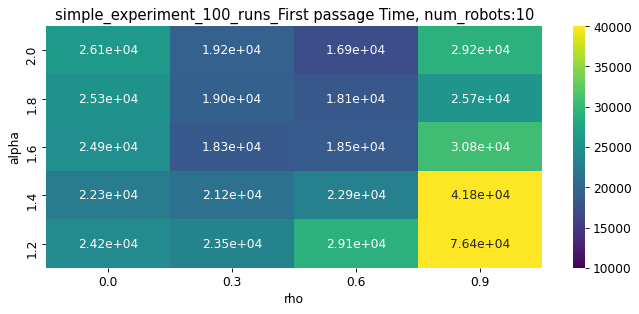

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_First passage Time_100_robots.png


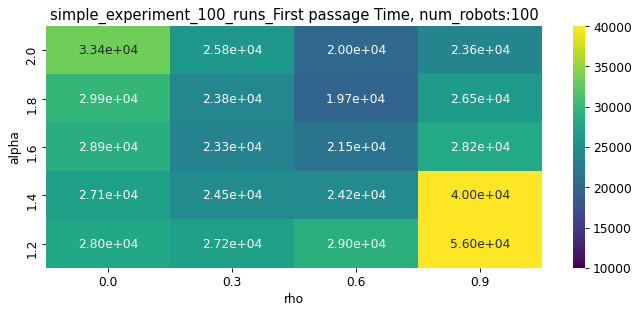

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_First passage Time_20_robots.png


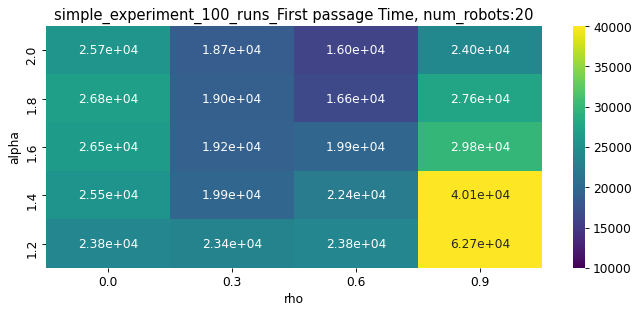

Saving heatmap at:  /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/simple_experiment_100_runs_First passage Time_50_robots.png


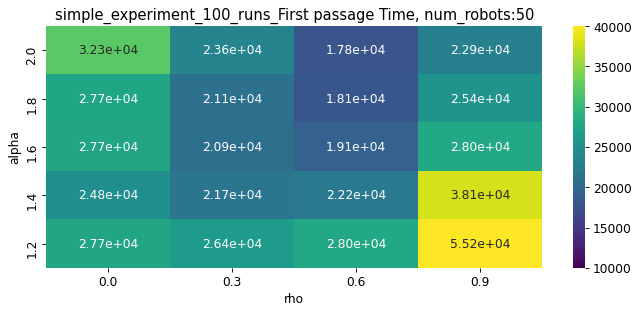

In [21]:
plot_heatmap(fpt_dict, folder_experiments.split("/")[-1]+'_First passage Time', False)